In [24]:
# Install dependencies (if running in Colab)
!pip install -q opencv-python

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import shutil
import os

# List of files to copy from Google Drive
files_to_copy = [
    "/content/drive/MyDrive/Mphil/MyPapers/LKenv/data2025/sat_images_2018_2025.zip",
    "/content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/LKdisasters2025_final_04.csv",
    "/content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/SriLanka_daily_weather_data_2018_09_2025_06.csv",
    "/content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/Weather_stations.csv"
]

# Copy each file to /content preserving only filename
for src_path in files_to_copy:
    dest_path = os.path.join("/content", os.path.basename(src_path))
    shutil.copy(src_path, dest_path)
    print(f"* Copied: {src_path} → {dest_path}")


* Copied: /content/drive/MyDrive/Mphil/MyPapers/LKenv/data2025/sat_images_2018_2025.zip → /content/sat_images_2018_2025.zip
* Copied: /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/LKdisasters2025_final_04.csv → /content/LKdisasters2025_final_04.csv
* Copied: /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/SriLanka_daily_weather_data_2018_09_2025_06.csv → /content/SriLanka_daily_weather_data_2018_09_2025_06.csv
* Copied: /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/Weather_stations.csv → /content/Weather_stations.csv


In [27]:
# --- Step 1: Import Libraries ---
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime

In [28]:
# --- Step 3: Extract Satellite Images from ZIP ---
sat_img_dir = '/content/sat_images'
os.makedirs(sat_img_dir, exist_ok=True)

In [29]:
with zipfile.ZipFile('/content/sat_images_2018_2025.zip', 'r') as zip_ref:
    zip_ref.extractall(sat_img_dir)

In [30]:
img = np.load('/content/sat_images/2018-10-31.npy')
print("dtype:", img.dtype)
print("min:", img.min(), "| max:", img.max())

dtype: float64
min: 0.00784313725490196 | max: 0.9921568627450981


In [31]:


# === CONFIG ===
SAT_DIR = '/content/sat_images/'
OUT_CSV = '/content/satellite_images_128.csv'

# === List and Extract Dates ===
npy_files = [f for f in os.listdir(SAT_DIR) if f.endswith('.npy')]

data = []
for fname in npy_files:
    try:
        # Extract date from filename: YYYY_MM_DD.npy → YYYY-MM-DD
        date_str = os.path.splitext(fname)[0]
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        date_iso = date_obj.date().isoformat()
        full_path = os.path.join(SAT_DIR, fname).replace('\\', '/')  # force Unix-style
        data.append((date_iso, full_path))
    except ValueError as e:
        print(f"Skipping {fname}: {e}")

# === Create DataFrame ===
df_sat = pd.DataFrame(data, columns=["date", "path"])
df_sat = df_sat.sort_values("date").reset_index(drop=True)

# === Save CSV ===
df_sat.to_csv(OUT_CSV, index=False)
print(f"Saved {OUT_CSV} with {len(df_sat)} entries.")

# === Preview Head ===
df_sat

Saved /content/satellite_images_128.csv with 1373 entries.


,date,path
0,2018-10-31,/content/sat_images/2018-10-31.npy
1,2018-11-01,/content/sat_images/2018-11-01.npy
2,2018-11-02,/content/sat_images/2018-11-02.npy
3,2018-11-03,/content/sat_images/2018-11-03.npy
4,2018-11-04,/content/sat_images/2018-11-04.npy
...,...,...
1368,2025-07-10,/content/sat_images/2025-07-10.npy
1369,2025-07-11,/content/sat_images/2025-07-11.npy
1370,2025-07-12,/content/sat_images/2025-07-12.npy
1371,2025-07-13,/content/sat_images/2025-07-13.npy


In [32]:
import numpy as np

# Example: Load the first satellite image
first_image_path = df_sat['path'].iloc[0]
image_array = np.load(first_image_path)

# Check shape and pixel stats
print(image_array.shape)
print(image_array.min(), image_array.max())


(128, 128, 3)
0.00784313725490196 0.9921568627450981


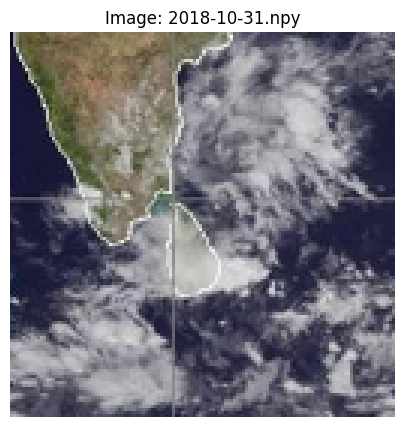

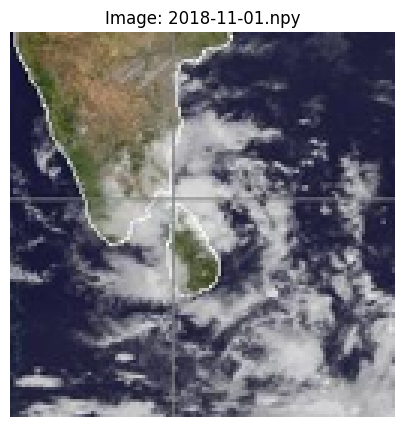

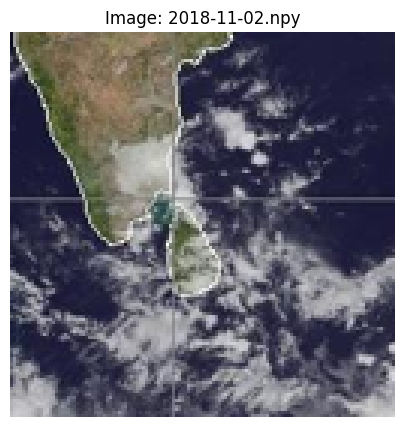

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os


# List and sort npy files
npy_files = sorted([f for f in os.listdir(SAT_DIR) if f.endswith('.npy')])

# Load and plot top 3 images
for i, fname in enumerate(npy_files[:3]):
    fpath = os.path.join(SAT_DIR, fname)
    try:
        img = np.load(fpath)

        plt.figure(figsize=(5, 5))
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        elif img.ndim == 3:
            if img.shape[0] <= 4:  # Channels-first
                img = np.moveaxis(img, 0, -1)
            plt.imshow(img[:, :, :3])  # First 3 channels
        else:
            raise ValueError("Unsupported image shape:", img.shape)

        plt.title(f"Image: {fname}")
        plt.axis('off')
        plt.show()
        print()

    except Exception as e:
        print(f"X Could not load {fname}: {e}")


## Weather Data

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
weather_df = pd.read_csv('SriLanka_daily_weather_data_2018_09_2025_06.csv')

# Ensure date column is parsed correctly
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')
weather_df = weather_df.dropna(subset=['date'])
weather_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49182 entries, 0 to 49181
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     49182 non-null  datetime64[ns]
 1   city                     49182 non-null  object        
 2   latitude                 49182 non-null  float64       
 3   longitude                49182 non-null  float64       
 4   dewpoint_temperature_2m  39814 non-null  float64       
 5   rainfall_mm              39814 non-null  float64       
 6   surface_pressure         39814 non-null  float64       
 7   temperature_2m           39814 non-null  float64       
 8   u_component_of_wind_10m  39814 non-null  float64       
 9   v_component_of_wind_10m  39814 non-null  float64       
 10  temperature_2m_c         39814 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 4.1+ MB


In [35]:
weather_df = weather_df.dropna().reset_index(drop=True)

In [36]:
weather_df.describe()

,date,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c
count,39814,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000,39814.000000
mean,2022-02-26 21:07:13.475661824,7.535045,80.593314,295.145390,5.720584,98137.809420,298.848153,0.580677,0.420206,25.698153
min,2018-11-01 00:00:00,6.585395,79.861244,278.296618,-0.000028,84888.585124,288.856986,-8.546980,-12.092460,15.706986
25%,2020-06-08 00:00:00,6.916667,80.033333,293.947989,0.373440,98522.567017,297.557963,-0.799895,-0.849836,24.407963
50%,2022-02-13 12:00:00,7.180000,80.500000,295.805338,1.935609,100021.456462,299.272771,0.441448,0.199651,26.122771
75%,2023-12-23 00:00:00,8.016667,81.033333,296.775633,6.471805,100744.382650,300.647543,2.016018,1.817622,27.497543
max,2025-06-30 00:00:00,9.750000,81.833333,300.600016,215.747893,101660.440592,304.915415,10.472853,10.162131,31.765415
std,NaN,0.871180,0.588926,2.317186,10.477001,4173.891915,2.617343,2.129508,2.258714,2.617343


In [37]:
weather_df['dewpoint_temperature_2m_c'] = weather_df['dewpoint_temperature_2m'] - 273.15

In [38]:
invalid_rows = weather_df[
    (weather_df['dewpoint_temperature_2m_c'] > weather_df['temperature_2m_c'])
]

print(f" Invalid humidity rows: {len(invalid_rows)} / {len(weather_df)}")


 Invalid humidity rows: 0 / 39814


In [39]:
import pandas as pd
import numpy as np

# STEP 1: Load weather stations list
stations_df = pd.read_csv('/content/Weather_stations.csv')
stations_df['City'] = stations_df['City'].str.strip()

# Preview unique station list
known_cities = stations_df['City'].unique()
print(" Known weather cities:", known_cities)

# STEP 1: Compute humidity safely (dew point must be ≤ temp)
temp = weather_df['temperature_2m_c']
dew_point = weather_df['dewpoint_temperature_2m']
valid_mask = temp.notna() & dew_point.notna() & (dew_point <= temp)

def compute_rh(t, td):
    return 100 * (np.exp((17.625 * td) / (243.04 + td)) /
                  np.exp((17.625 * t) / (243.04 + t)))

weather_df['humidity'] = np.nan
weather_df.loc[valid_mask, 'humidity'] = compute_rh(
    temp[valid_mask], dew_point[valid_mask]
).clip(0, 100)

# STEP 2: Use updated zone map
city_zone_map = {
    'Colombo': 'Wet', 'Kandy': 'Wet', 'Nuwara Eliya': 'Wet', 'Galle': 'Wet',
    'Kurunegala': 'Intermediate', 'Matale': 'Intermediate', 'Rathnapura': 'Wet',
    'Hambantota': 'Dry', 'Mannar': 'Dry', 'Trincomalee': 'Dry',
    'Puttalam': 'VeryDry', 'Ampara': 'VeryDry', 'Monaragala': 'VeryDry',
    'Anuradhapura': 'Dry', 'Arugambay': 'VeryDry', 'Badulla': 'Wet', 'Bandarawela': 'Wet',
    'Batticaloa': 'VeryDry', 'Jaffna': 'VeryDry', 'Kalutara': 'Wet', 'Katunayake': 'Wet',
    'MahaIlluppallama': 'Dry', 'NuwaraEliya': 'VeryWet', 'Pottuvil': 'Dry',
    'Ratnapura': 'Wet', 'Vavuniya': 'VeryDry'
}

# STEP 3: Zone → default RH mapping
zone_rh = {
    'VeryWet': 90,
    'Wet': 85,
    'Intermediate': 78,
    'Dry': 68,
    'VeryDry': 60
}
default_rh = 75

# STEP 4: Fill missing humidity
def get_zone_rh(city):
    zone = city_zone_map.get(city, None)
    return zone_rh.get(zone, default_rh)

weather_df['humidity_filled'] = weather_df.apply(
    lambda row: get_zone_rh(row['city']) if pd.isna(row['humidity']) else row['humidity'],
    axis=1
)
# Drop old humidity column
weather_df = weather_df.drop(columns=['humidity'])

# Rename humidity_filled to humidity
weather_df = weather_df.rename(columns={'humidity_filled': 'humidity'})

weather_df

 Known weather cities: ['Kandy' 'Colombo' 'Kurunegala' 'Galle' 'Jaffna' 'Anuradhapura'
 'Arugambay' 'Badulla' 'Bandarawela' 'Batticaloa' 'Hambantota' 'Kalutara'
 'Katunayake' 'MahaIlluppallama' 'Mannar' 'NuwaraEliya' 'Pottuvil'
 'Puttalam' 'Ratnapura' 'Trincomalee' 'Vavuniya']


,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity
0,2018-11-01,Anuradhapura,8.366667,80.433333,296.477772,16.779113,99827.154785,297.064706,0.215283,0.934671,23.914706,23.327772,68
1,2018-11-01,Arugambay,6.748889,81.690000,296.912098,10.641816,100334.821452,298.879077,0.008069,-1.825399,25.729077,23.762098,60
2,2018-11-01,Badulla,7.016667,81.033333,293.332915,23.515958,91817.904785,294.454924,0.135632,-0.329550,21.304924,20.182915,85
3,2018-11-01,Bandarawela,6.816667,81.058333,294.219552,36.926451,93880.529785,295.275399,-0.076913,-0.524842,22.125399,21.069552,85
4,2018-11-01,Colombo,6.927079,79.861244,297.045968,15.894938,100906.238118,298.807625,0.279187,-1.197612,25.657625,23.895968,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39809,2025-06-30,Pottuvil,6.916667,81.833333,296.270713,0.000426,100368.703939,302.907599,2.176819,4.245193,29.757599,23.120713,68
39810,2025-06-30,Puttalam,8.016667,79.916667,297.225953,0.067526,100451.453939,301.285936,3.548239,2.969273,28.135936,24.075953,60
39811,2025-06-30,Ratnapura,6.700000,80.400000,295.736451,2.345318,98542.245605,298.172980,1.444357,-1.085170,25.022980,22.586451,85
39812,2025-06-30,Trincomalee,8.592200,81.196793,295.518597,0.130826,100375.620605,303.656460,3.907207,2.126785,30.506460,22.368597,68


## Disasters

In [40]:
disasters = pd.read_csv("LKdisasters2025_final_04.csv")

# Rename columns: lowercase, strip spaces, replace spaces and special chars with underscores
disasters.columns = (
    disasters.columns
    .str.strip()
    .str.lower()
    .str.replace(r'[^a-zA-Z0-9]', '_', regex=True)
    .str.replace(r'_+', '_', regex=True)  # collapse multiple underscores
    .str.strip('_')  # remove leading/trailing underscores
)
disasters.rename(columns={'event': 'disaster_type'}, inplace=True)
disasters['raw_severity'] = (
    disasters['deaths'] * 10 +
    disasters['injured'] * 5 +
    disasters['missing'] * 8 +
    disasters['houses_destroyed'] * 4 +
    disasters['houses_damaged'] * 2 +
    disasters['indirectly_affected'] * 1
)
# Min-max normalization between 1 and 10
min_val = disasters['raw_severity'].min()
max_val = disasters['raw_severity'].max()

disasters['severity'] = 1 + 9 * (disasters['raw_severity'] - min_val) / (max_val - min_val)
disasters['severity'] = disasters['severity'].round(2)
disasters.drop(columns=['raw_severity'], inplace=True)
disasters.columns
# Preview


Index(['serial', 'disaster_type', 'province', 'district', 'division', 'date',
       'deaths', 'injured', 'missing', 'houses_destroyed', 'houses_damaged',
       'indirectly_affected', 'damages_in_crops_ha', 'lost_cattle',
       'damages_in_roads_mts', 'severity', 'severity_category'],
      dtype='object')

In [41]:
# Step 3: Convert 'Date' columns to datetime
disasters['date'] = pd.to_datetime(disasters['date'], errors='coerce')
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')

# Step 4: Normalize location fields
disasters['district'] = disasters['district'].astype(str).str.strip().str.lower()
weather_df['city'] = weather_df['city'].astype(str).str.strip().str.lower()

# Step 5: Mapping from district to station/city
location_map = {
    'ampara': 'ampara',
    'anuradhapura': 'anuradhapura',
    'arugambay': 'arugambay',
    'badulla': 'badulla',
    'bandarawela': 'bandarawela',
    'batticaloa': 'batticaloa',
    'colombo': 'colombo',
    'galle': 'galle',
    'hambantota': 'hambantota',
    'jaffna': 'jaffna',
    'kalutara': 'kalutara',
    'kandy': 'kandy',
    'katunayake': 'katunayake',
    'kurunegala': 'kurunegala',
    'mahailluppallama': 'mahailluppallama',
    'mannar': 'mannar',
    'matale': 'matale',
    'monaragala': 'monaragala',
    'nuwaraeliya': 'nuwaraeliya',
    'pottuvil': 'pottuvil',
    'puttalam': 'puttalam',
    'ratnapura': 'ratnapura',
    'trincomalee': 'trincomalee',
    'vavuniya': 'vavuniya'
}
# Step 6: Apply mapping
disasters['location'] = disasters['district'].map(location_map)
disasters = disasters.dropna(subset=['location'])

# Step 7: Add Simple_Location columns (title-cased for reporting)
disasters['simple_location'] = disasters['location'].str.replace('_', ' ').str.title()
weather_df['simple_location'] = weather_df['city'].str.replace('_', ' ').str.title()

# Step 8 (Optional): Preview simplified results
print("Disaster Locations:")
print(disasters[['district', 'location', 'simple_location']].drop_duplicates().head(20))

print("\nWeather Stations:")
print(weather_df[['city', 'simple_location']].drop_duplicates().head(20))
print(weather_df.info())
print(disasters.info())

Disaster Locations:
         district      location simple_location
2      batticaloa    batticaloa      Batticaloa
3        kalutara      kalutara        Kalutara
7           kandy         kandy           Kandy
15       puttalam      puttalam        Puttalam
16          galle         galle           Galle
39        colombo       colombo         Colombo
62   anuradhapura  anuradhapura    Anuradhapura
64         mannar        mannar          Mannar
89     kurunegala    kurunegala      Kurunegala
94     hambantota    hambantota      Hambantota
103        matale        matale          Matale
109      vavuniya      vavuniya        Vavuniya
110        ampara        ampara          Ampara
120       badulla       badulla         Badulla
125        jaffna        jaffna          Jaffna
127     ratnapura     ratnapura       Ratnapura
169   trincomalee   trincomalee     Trincomalee

Weather Stations:
                city   simple_location
0       anuradhapura      Anuradhapura
1          arugamba

/tmp/ipython-input-41-2654730328.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disasters['simple_location'] = disasters['location'].str.replace('_', ' ').str.title()


In [42]:
disasters

,serial,disaster_type,province,district,division,date,deaths,injured,missing,houses_destroyed,houses_damaged,indirectly_affected,damages_in_crops_ha,lost_cattle,damages_in_roads_mts,severity,severity_category,location,simple_location
2,141124,LIGHTNING,Eastern,batticaloa,Eravur Pattu (Chenkalady),2018-10-02,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0,0.0,1.00,Low,batticaloa,Batticaloa
3,141596,FLOOD,Western,kalutara,Dodangoda,2018-10-03,0.0,1.0,0.0,2.0,13.0,918.0,0.0,0,0.0,1.09,Low,kalutara,Kalutara
7,141082,STRONG WIND,Central,kandy,Medadumbara,2018-10-04,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0,0.0,1.00,Low,kandy,Kandy
12,141080,STRONG WIND,Central,kandy,Yatinuwara,2018-10-05,0.0,0.0,0.0,2.0,88.0,346.0,0.0,0,0.0,1.05,Low,kandy,Kandy
14,141081,STRONG WIND,Central,kandy,Udunuwara,2018-10-05,0.0,3.0,0.0,0.0,74.0,291.0,0.0,0,0.0,1.04,Low,kandy,Kandy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,144169,STRONG WIND,Central,kandy,Harispattuwa,2020-02-20,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0,0.0,1.00,Low,kandy,Kandy
2091,144168,STRONG WIND,Southern,hambantota,Tangalle,2020-02-22,0.0,0.0,0.0,0.0,2.0,6.0,0.0,0,0.0,1.00,Low,hambantota,Hambantota
2092,144175,STRONG WIND,North-Western,puttalam,Nawagattegama,2020-02-22,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0,0.0,1.00,Low,puttalam,Puttalam
2093,144172,STRONG WIND,Central,kandy,Doluwa,2020-02-23,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0,0.0,1.00,Low,kandy,Kandy


In [43]:
disasters['disaster_type'].unique()


array(['LIGHTNING', 'FLOOD', 'STRONG WIND', 'FLASH FLOOD', 'CYCLONE',
       'DROUGHT', 'LANDSLIDE', 'TORNADO'], dtype=object)

In [44]:
weather_df

,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity,simple_location
0,2018-11-01,anuradhapura,8.366667,80.433333,296.477772,16.779113,99827.154785,297.064706,0.215283,0.934671,23.914706,23.327772,68,Anuradhapura
1,2018-11-01,arugambay,6.748889,81.690000,296.912098,10.641816,100334.821452,298.879077,0.008069,-1.825399,25.729077,23.762098,60,Arugambay
2,2018-11-01,badulla,7.016667,81.033333,293.332915,23.515958,91817.904785,294.454924,0.135632,-0.329550,21.304924,20.182915,85,Badulla
3,2018-11-01,bandarawela,6.816667,81.058333,294.219552,36.926451,93880.529785,295.275399,-0.076913,-0.524842,22.125399,21.069552,85,Bandarawela
4,2018-11-01,colombo,6.927079,79.861244,297.045968,15.894938,100906.238118,298.807625,0.279187,-1.197612,25.657625,23.895968,85,Colombo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39809,2025-06-30,pottuvil,6.916667,81.833333,296.270713,0.000426,100368.703939,302.907599,2.176819,4.245193,29.757599,23.120713,68,Pottuvil
39810,2025-06-30,puttalam,8.016667,79.916667,297.225953,0.067526,100451.453939,301.285936,3.548239,2.969273,28.135936,24.075953,60,Puttalam
39811,2025-06-30,ratnapura,6.700000,80.400000,295.736451,2.345318,98542.245605,298.172980,1.444357,-1.085170,25.022980,22.586451,85,Ratnapura
39812,2025-06-30,trincomalee,8.592200,81.196793,295.518597,0.130826,100375.620605,303.656460,3.907207,2.126785,30.506460,22.368597,68,Trincomalee


In [45]:
# Step 1: Convert to datetime
disasters['date'] = pd.to_datetime(disasters['date'], errors='coerce')
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')

# Step 2: Normalize locations
disasters['district'] = disasters['district'].astype(str).str.strip().str.lower()
weather_df['city'] = weather_df['city'].astype(str).str.strip().str.lower()

# Step 3: Location mapping
location_map = {
    'ampara':'ampara', 'anuradhapura': 'anuradhapura', 'arugambay': 'arugambay',
    'badulla': 'badulla', 'bandarawela': 'bandarawela', 'batticaloa': 'batticaloa',
    'colombo': 'colombo', 'galle': 'galle', 'hambantota': 'hambantota',
    'jaffna': 'jaffna', 'kalutara': 'kalutara', 'kandy': 'kandy',
    'katunayake': 'katunayake', 'kurunegala': 'kurunegala', 'mahailluppallama': 'mahailluppallama',
    'mannar': 'mannar', 'matale': 'matale', 'monaragala':'monaragala',
    'nuwaraeliya': 'nuwaraeliya', 'pottuvil': 'pottuvil', 'puttalam': 'puttalam',
    'ratnapura': 'ratnapura', 'trincomalee': 'trincomalee', 'vavuniya': 'vavuniya'
}
disasters['location'] = disasters['district'].map(location_map)
disasters = disasters.dropna(subset=['location'])

# Step 4: Create merge keys
disasters['merge_key'] = disasters['date'].dt.date.astype(str) + "_" + disasters['location']
weather_df['merge_key'] = weather_df['date'].dt.date.astype(str) + "_" + weather_df['city']

# Step 5: Focus period = disaster period
start_date = pd.to_datetime('2018-12-15')
end_date = pd.to_datetime('2020-03-15')  # use same date window
weather_df = weather_df[(weather_df['date'] >= start_date) & (weather_df['date'] <= end_date)]

weather_df

,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity,simple_location,merge_key
748,2018-12-15,anuradhapura,8.366667,80.433333,295.237538,2.072802,100002.055501,298.044692,0.791788,-2.667122,24.894692,22.087538,68,Anuradhapura,2018-12-15_anuradhapura
749,2018-12-15,arugambay,6.748889,81.690000,295.260324,0.566503,100417.722168,299.404067,1.568379,-1.741137,26.254067,22.110324,60,Arugambay,2018-12-15_arugambay
750,2018-12-15,badulla,7.016667,81.033333,291.717112,0.366500,91912.847168,294.733087,0.790629,-1.007495,21.583087,18.567112,85,Badulla,2018-12-15_badulla
751,2018-12-15,bandarawela,6.816667,81.058333,292.503407,0.996894,93961.597168,295.533624,0.427958,-0.732267,22.383624,19.353407,85,Bandarawela,2018-12-15_bandarawela
752,2018-12-15,colombo,6.927079,79.861244,295.889719,2.314499,101064.097168,298.978611,0.119181,-3.992765,25.828611,22.739719,85,Colombo,2018-12-15_colombo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8512,2020-03-15,pottuvil,6.916667,81.833333,295.627976,0.642657,100651.672526,301.314933,-2.209468,-3.296523,28.164933,22.477976,68,Pottuvil,2020-03-15_pottuvil
8513,2020-03-15,puttalam,8.016667,79.916667,293.831996,0.000000,100659.172526,302.941805,-2.362097,-1.692479,29.791805,20.681996,60,Puttalam,2020-03-15_puttalam
8514,2020-03-15,ratnapura,6.700000,80.400000,295.943813,4.857928,98587.839193,299.327791,0.266158,0.160874,26.177791,22.793813,85,Ratnapura,2020-03-15_ratnapura
8515,2020-03-15,trincomalee,8.592200,81.196793,294.761602,0.100672,100814.297526,301.527335,-3.665157,-1.581680,28.377335,21.611602,68,Trincomalee,2020-03-15_trincomalee


## Merge

In [46]:
# Step 6: Merge with disaster_type and severity included
merged = pd.merge(
    weather_df,
    disasters[['merge_key', 'date', 'disaster_type', 'severity']].rename(columns={'date': 'disaster_date'}),
    on='merge_key',
    how='left'
)

merged.drop(columns=['merge_key'], inplace=True)
# Step 7: Label disaster presence
merged['has_disaster'] = merged['disaster_date'].notnull().astype(int)
merged['has_disaster'].value_counts()

,count
has_disaster,
0,7403
1,811


In [47]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8214 entries, 0 to 8213
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       8214 non-null   datetime64[ns]
 1   city                       8214 non-null   object        
 2   latitude                   8214 non-null   float64       
 3   longitude                  8214 non-null   float64       
 4   dewpoint_temperature_2m    8214 non-null   float64       
 5   rainfall_mm                8214 non-null   float64       
 6   surface_pressure           8214 non-null   float64       
 7   temperature_2m             8214 non-null   float64       
 8   u_component_of_wind_10m    8214 non-null   float64       
 9   v_component_of_wind_10m    8214 non-null   float64       
 10  temperature_2m_c           8214 non-null   float64       
 11  dewpoint_temperature_2m_c  8214 non-null   float64       
 12  humidi

Visualize rainfall vs disaster frequency

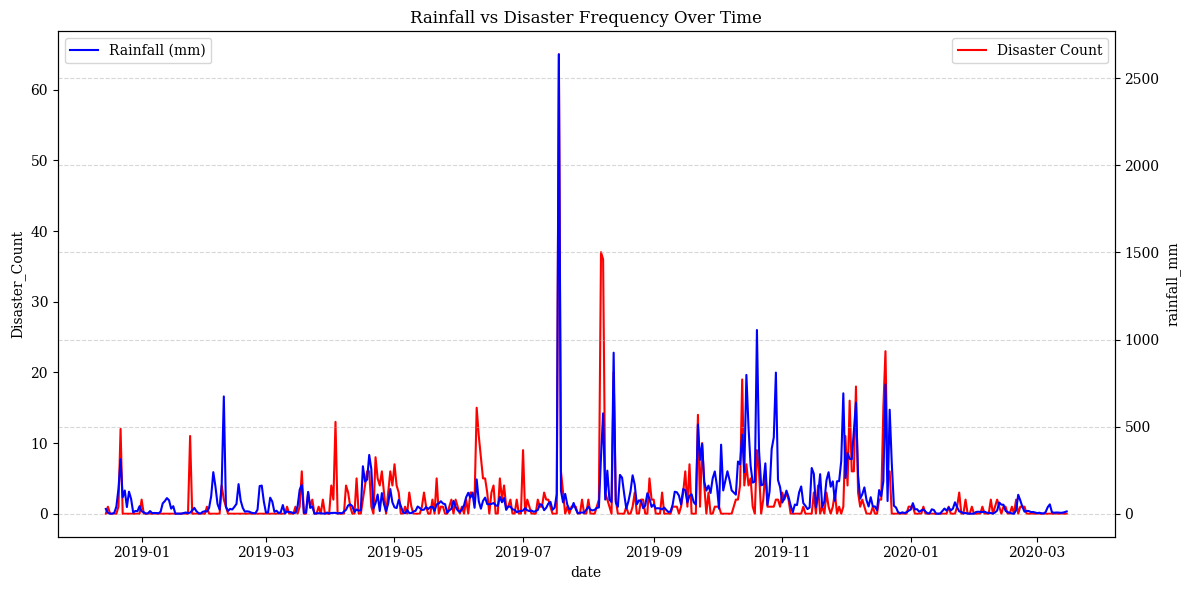

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'serif'
# Step 1: Convert to datetime (if not already)
merged['date'] = pd.to_datetime(merged['date'])

# Step 2: Group by date → count disasters and sum rainfall
daily_stats = merged.groupby('date').agg({
    'disaster_type': 'count',
    'rainfall_mm': 'sum'
}).rename(columns={'disaster_type': 'Disaster_Count'})

# Step 3: Plot disaster frequency vs rainfall
plt.figure(figsize=(12, 6))

# Plot disaster count
sns.lineplot(data=daily_stats, x='date', y='Disaster_Count', label='Disaster Count', color='red')

# Plot rainfall on secondary y-axis
ax2 = plt.gca().twinx()
sns.lineplot(data=daily_stats, x='date', y='rainfall_mm', label='Rainfall (mm)', color='blue', ax=ax2)

# Final touches
plt.title('Rainfall vs Disaster Frequency Over Time')
plt.xlabel('Date')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig("Rainfall+Disaster_Over_Time.png", dpi=300, bbox_inches='tight')
plt.show()


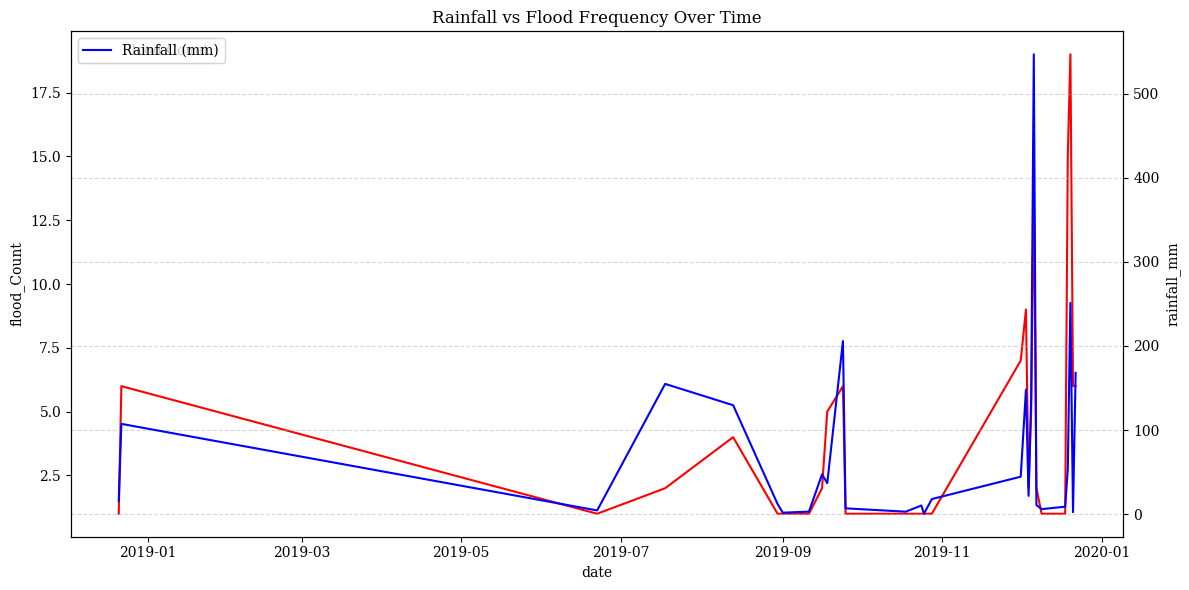

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter for 'Flood' disasters
flood_df = merged[merged['disaster_type'].str.lower() == 'flood'].copy()

# Step 2: Convert Date column if needed
flood_df['Date'] = pd.to_datetime(flood_df['date'])

# Step 3: Group by Date → count floods and total rainfall
flood_daily = flood_df.groupby('date').agg({
    'disaster_type': 'count',
    'rainfall_mm': 'sum'
}).rename(columns={'disaster_type': 'flood_Count'})

# Step 4: Plot
plt.figure(figsize=(12, 6))

# Flood count plot
sns.lineplot(data=flood_daily, x='date', y='flood_Count', label='Flood Count', color='red')

# Rainfall on secondary y-axis
ax2 = plt.gca().twinx()
sns.lineplot(data=flood_daily, x='date', y='rainfall_mm', label='Rainfall (mm)', color='blue', ax=ax2)

# Finishing touches
plt.title('Rainfall vs Flood Frequency Over Time')
plt.xlabel('Date')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig("ainfall_flood_Frequency.png", dpi=300, bbox_inches='tight')
plt.show()


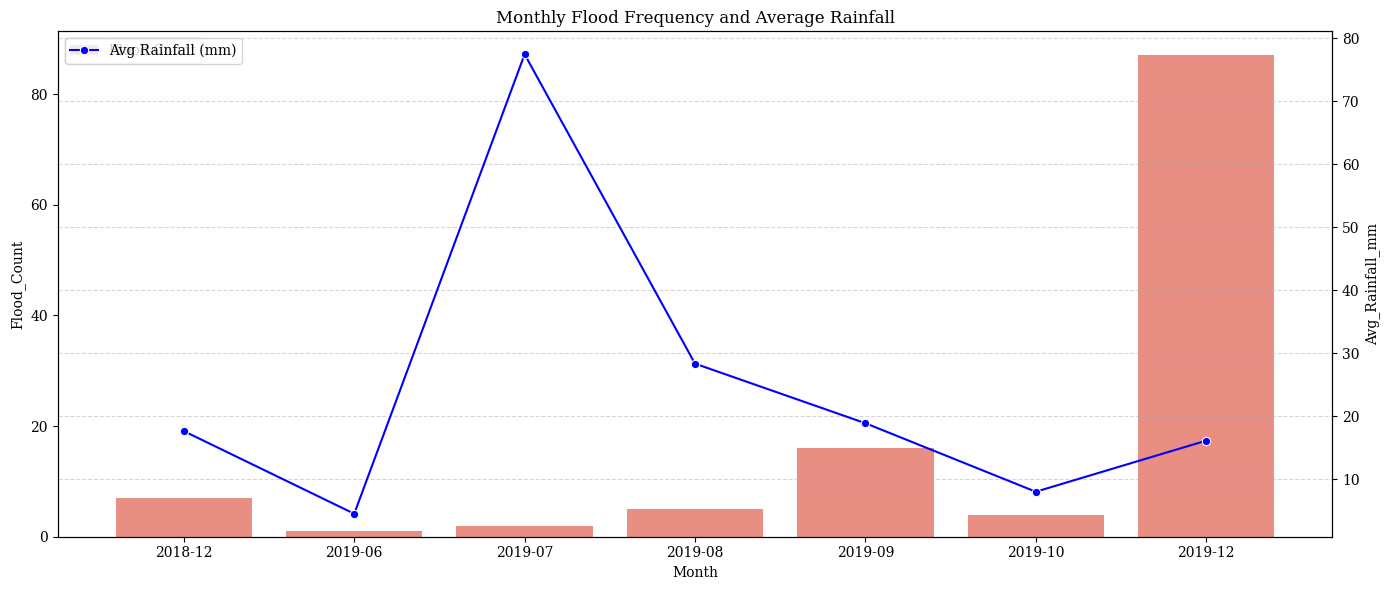

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter flood-related disasters
flood_df = merged[merged['disaster_type'].str.lower() == 'flood'].copy()
flood_df['date'] = pd.to_datetime(flood_df['date'])

# Step 2: Extract month in YYYY-MM format
flood_df['Month'] = flood_df['date'].dt.to_period('M').astype(str)

# Step 3: Group by Month → count floods and average rainfall
monthly_stats = flood_df.groupby('Month').agg({
    'disaster_type': 'count',
    'rainfall_mm': 'mean'
}).rename(columns={'disaster_type': 'Flood_Count', 'rainfall_mm': 'Avg_Rainfall_mm'})

# Step 4: Plot monthly flood frequency and rainfall
plt.figure(figsize=(14, 6))

# Bar plot for flood count
sns.barplot(x=monthly_stats.index, y=monthly_stats['Flood_Count'], color='salmon', label='Flood Count')

# Line plot on secondary axis for rainfall
ax2 = plt.gca().twinx()
sns.lineplot(x=monthly_stats.index, y=monthly_stats['Avg_Rainfall_mm'], color='blue', marker='o', label='Avg Rainfall (mm)', ax=ax2)

# Final formatting
plt.title("Monthly Flood Frequency and Average Rainfall")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig("Monthly_flood_Frequency_Rainfall.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1400x700 with 0 Axes>

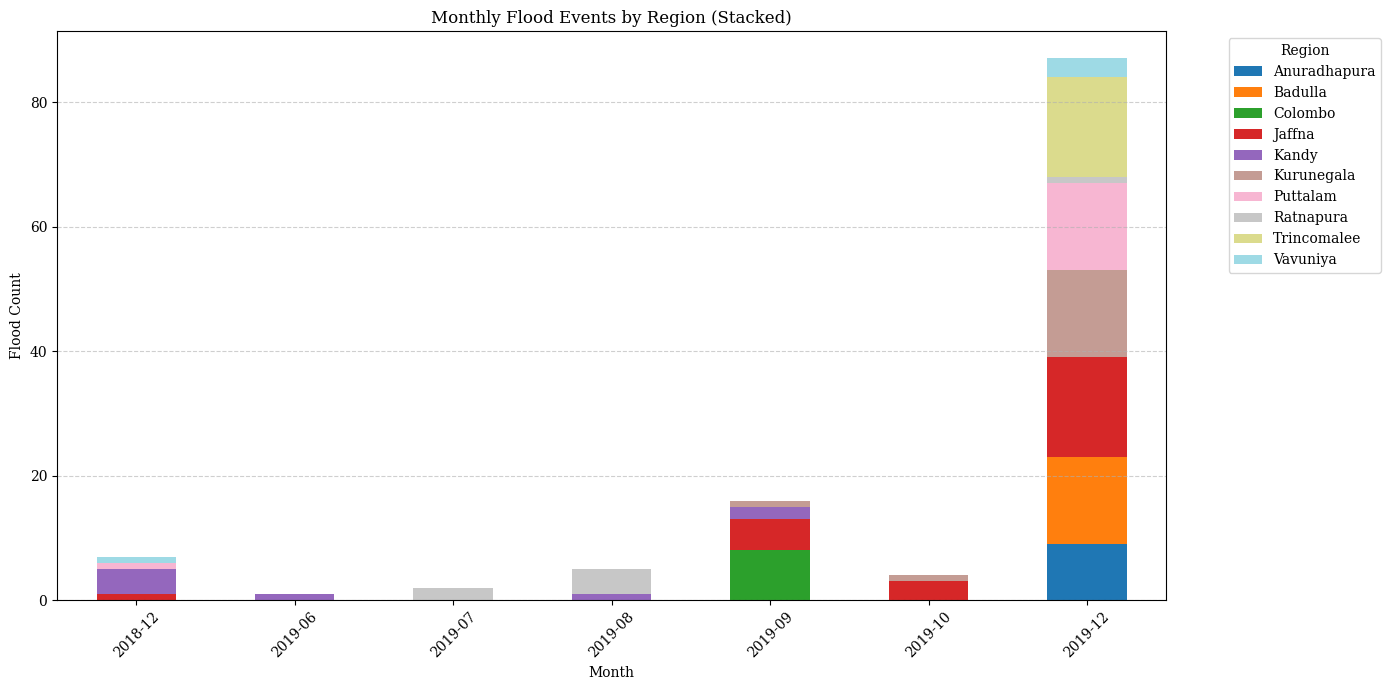

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter only flood disasters and convert date
flood_df = merged[merged['disaster_type'].str.lower() == 'flood'].copy()
flood_df['date'] = pd.to_datetime(flood_df['date'])
flood_df['Month'] = flood_df['date'].dt.to_period('M').astype(str)

# Step 2: Count floods per (Month, Region)
flood_by_region = flood_df.groupby(['Month', 'simple_location']).size().unstack(fill_value=0)

# Step 3: Plot stacked bar chart
plt.figure(figsize=(14, 7))
flood_by_region.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')

plt.title("Monthly Flood Events by Region (Stacked)")
plt.xlabel("Month")
plt.ylabel("Flood Count")
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Monthly_flood_Region.png", dpi=300, bbox_inches='tight')
plt.show()


Anomaly Geolocation Map

In [52]:
import os

# Step 1: Convert date to string format matching filenames
merged['date_str'] = merged['date'].dt.strftime('%Y-%m-%d')

# Step 2: Define base path where .npy files are stored
base_path = "/content/sat_images"

# Step 3: Check file existence and assign path if found
def get_image_path(date_str):
    file_path = os.path.join(base_path, f"{date_str}.npy")
    return file_path if os.path.isfile(file_path) else None

merged['path'] = merged['date_str'].apply(get_image_path)

# Optional: Preview missing files
missing_files = merged['path'].isna().sum()
print(f"Satellite image files not found: {missing_files} out of {len(merged)}")
merged

Satellite image files not found: 3947 out of 8214


,date,city,latitude,longitude,dewpoint_temperature_2m,rainfall_mm,surface_pressure,temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,temperature_2m_c,dewpoint_temperature_2m_c,humidity,simple_location,disaster_date,disaster_type,severity,has_disaster,date_str,path
0,2018-12-15,anuradhapura,8.366667,80.433333,295.237538,2.072802,100002.055501,298.044692,0.791788,-2.667122,24.894692,22.087538,68,Anuradhapura,NaT,NaN,NaN,0,2018-12-15,/content/sat_images/2018-12-15.npy
1,2018-12-15,arugambay,6.748889,81.690000,295.260324,0.566503,100417.722168,299.404067,1.568379,-1.741137,26.254067,22.110324,60,Arugambay,NaT,NaN,NaN,0,2018-12-15,/content/sat_images/2018-12-15.npy
2,2018-12-15,badulla,7.016667,81.033333,291.717112,0.366500,91912.847168,294.733087,0.790629,-1.007495,21.583087,18.567112,85,Badulla,NaT,NaN,NaN,0,2018-12-15,/content/sat_images/2018-12-15.npy
3,2018-12-15,bandarawela,6.816667,81.058333,292.503407,0.996894,93961.597168,295.533624,0.427958,-0.732267,22.383624,19.353407,85,Bandarawela,NaT,NaN,NaN,0,2018-12-15,/content/sat_images/2018-12-15.npy
4,2018-12-15,colombo,6.927079,79.861244,295.889719,2.314499,101064.097168,298.978611,0.119181,-3.992765,25.828611,22.739719,85,Colombo,NaT,NaN,NaN,0,2018-12-15,/content/sat_images/2018-12-15.npy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8209,2020-03-15,pottuvil,6.916667,81.833333,295.627976,0.642657,100651.672526,301.314933,-2.209468,-3.296523,28.164933,22.477976,68,Pottuvil,NaT,NaN,NaN,0,2020-03-15,None
8210,2020-03-15,puttalam,8.016667,79.916667,293.831996,0.000000,100659.172526,302.941805,-2.362097,-1.692479,29.791805,20.681996,60,Puttalam,NaT,NaN,NaN,0,2020-03-15,None
8211,2020-03-15,ratnapura,6.700000,80.400000,295.943813,4.857928,98587.839193,299.327791,0.266158,0.160874,26.177791,22.793813,85,Ratnapura,NaT,NaN,NaN,0,2020-03-15,None
8212,2020-03-15,trincomalee,8.592200,81.196793,294.761602,0.100672,100814.297526,301.527335,-3.665157,-1.581680,28.377335,21.611602,68,Trincomalee,NaT,NaN,NaN,0,2020-03-15,None


Merge Satellite Data

Extract .npy Features from merged_with_images

In [53]:
import numpy as np
from tqdm import tqdm
import os

# Initialize lists for brightness stats
mean_brightness = []
std_brightness = []
max_brightness = []
min_brightness = []

print("Processing satellite .npy files from 'path' column...")

# Loop over 'path' directly
for path in tqdm(merged['path']):
    if isinstance(path, str) and path.endswith(".npy") and os.path.isfile(path):
        try:
            img = np.load(path)
            mean_brightness.append(np.mean(img))
            std_brightness.append(np.std(img))
            max_brightness.append(np.max(img))
            min_brightness.append(np.min(img))
        except Exception as e:
            print(f"Error loading {path}: {e}")
            mean_brightness.append(np.nan)
            std_brightness.append(np.nan)
            max_brightness.append(np.nan)
            min_brightness.append(np.nan)
    else:
        mean_brightness.append(np.nan)
        std_brightness.append(np.nan)
        max_brightness.append(np.nan)
        min_brightness.append(np.nan)

# Attach features to the merged DataFrame
merged['mean_brightness'] = mean_brightness
merged['std_brightness'] = std_brightness
merged['max_brightness'] = max_brightness
merged['min_brightness'] = min_brightness

# Save the updated DataFrame
output_file = "weather_disaster_satellite_merged.csv"
merged.to_csv(output_file, index=False)

print(f"\nDone! Features saved to '{output_file}' with brightness stats.")
merged.info()

Processing satellite .npy files from 'path' column...


100%|██████████| 8214/8214 [00:01<00:00, 4449.09it/s]



Done! Features saved to 'weather_disaster_satellite_merged.csv' with brightness stats.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8214 entries, 0 to 8213
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       8214 non-null   datetime64[ns]
 1   city                       8214 non-null   object        
 2   latitude                   8214 non-null   float64       
 3   longitude                  8214 non-null   float64       
 4   dewpoint_temperature_2m    8214 non-null   float64       
 5   rainfall_mm                8214 non-null   float64       
 6   surface_pressure           8214 non-null   float64       
 7   temperature_2m             8214 non-null   float64       
 8   u_component_of_wind_10m    8214 non-null   float64       
 9   v_component_of_wind_10m    8214 non-null   float64       
 10  temperature_2m_c           8214 non-null   f

In [54]:
# Drop only metadata not needed for modeling
columns_to_drop_for_model = [
    'date', 'city', 'simple_location',
    'disaster_date', 'disaster_type', 'severity',
    'date_str', 'path'
]
# Full version (for inference and location tracking)
anomaly_df_full = merged.drop(columns=columns_to_drop_for_model)

# Model input version (drop lat/lon + labels too)
anomaly_df_model = anomaly_df_full.drop(columns=['latitude', 'longitude', 'has_disaster'])

# Save both
anomaly_df_full.to_csv("anomaly_detection_with_location.csv", index=False)
anomaly_df_model.to_csv("anomaly_detection_X_input.csv", index=False)

print(" Saved:")
print("- 'anomaly_detection_with_location.csv' (for inference)")
print("- 'anomaly_detection_X_input.csv' (for model input)")


 Saved:
- 'anomaly_detection_with_location.csv' (for inference)
- 'anomaly_detection_X_input.csv' (for model input)


## Anomaly Detection Preprocessing

* Load merged_final.csv

* Saves: X_windows.npy, y_windows.npy, lat_windows.npy, lon_windows.npy, y_daily.npy, and * Create 8-day sliding windows


In [55]:
# === Step 1: Setup ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === Step 2: Load Dataset ===
file_path = '/content/anomaly_detection_with_location.csv'  # Update if needed
df = pd.read_csv(file_path)

# === Step 3: Ensure temporal order ===
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date').reset_index(drop=True)

# === Step 4: Define columns ===
label_col = 'has_disaster'
lat_col = 'latitude'
lon_col = 'longitude'

# Separate model input features (drop label + lat/lon)
X_raw = df.drop(columns=[label_col, lat_col, lon_col])
y = df[label_col].values
lat = df[lat_col].values
lon = df[lon_col].values

# === Step 5: Normalize Features ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# === Step 6: Create Sliding Windows ===
WINDOW_SIZE = 8
X_windows, y_windows, lat_windows, lon_windows = [], [], [], []

for i in range(len(X_scaled) - WINDOW_SIZE + 1):
    X_windows.append(X_scaled[i:i+WINDOW_SIZE])
    y_windows.append(y[i:i+WINDOW_SIZE].max())             # Label: any anomaly in window
    lat_windows.append(lat[i+WINDOW_SIZE-1])               # Use last point in window
    lon_windows.append(lon[i+WINDOW_SIZE-1])

X_windows = np.array(X_windows) # training
y_windows = np.array(y_windows) # classification
lat_windows = np.array(lat_windows) #lat
lon_windows = np.array(lon_windows) #lon
y = np.array(y) #lon

# === Step 7: Save .npy Files ===
# Sliding window model input (3D array: samples × 8 days × features)
np.save('/content/X_windows.npy', X_windows)

# Binary label per window (1 if any of the 8 days had a disaster)
np.save('/content/y_windows.npy', y_windows)

# Latitude and longitude of the last day in each window (1D arrays)
np.save('/content/lat_windows.npy', lat_windows)
np.save('/content/lon_windows.npy', lon_windows)

# Original binary label per day (used to create y_windows)
np.save('/content/y_daily.npy', y)


print(f" Saved {X_windows.shape[0]} windows (shape: {X_windows.shape[1:]}).")



 Saved 8207 windows (shape: (8, 13)).


In [56]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8214 entries, 0 to 8213
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   dewpoint_temperature_2m    8214 non-null   float64
 1   rainfall_mm                8214 non-null   float64
 2   surface_pressure           8214 non-null   float64
 3   temperature_2m             8214 non-null   float64
 4   u_component_of_wind_10m    8214 non-null   float64
 5   v_component_of_wind_10m    8214 non-null   float64
 6   temperature_2m_c           8214 non-null   float64
 7   dewpoint_temperature_2m_c  8214 non-null   float64
 8   humidity                   8214 non-null   int64  
 9   mean_brightness            4267 non-null   float64
 10  std_brightness             4267 non-null   float64
 11  max_brightness             4267 non-null   float64
 12  min_brightness             4267 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 834.4 KB


In [57]:
df[label_col].values

array([0, 0, 0, ..., 0, 0, 0])

In [58]:
lat_windows

array([7.291418, 7.18    , 7.466667, ..., 6.7     , 8.5922  , 8.75    ])

In [59]:
lon_windows

array([80.636696, 79.883   , 80.366667, ..., 80.4     , 81.196793,
       80.5     ])

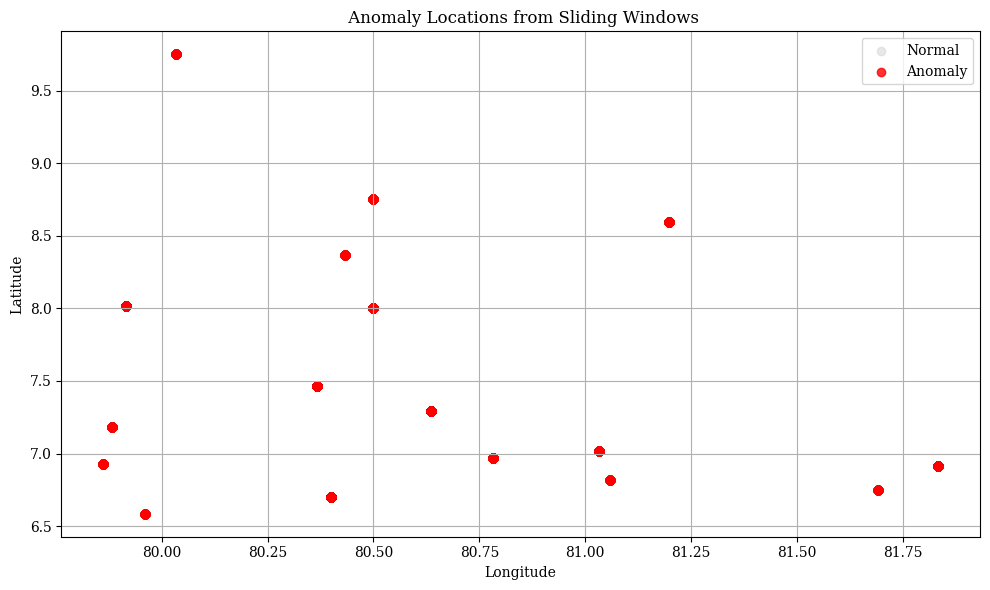

In [60]:
# === Step 8: Visualize Anomaly Map ===
plt.figure(figsize=(10, 6))
plt.scatter(lon_windows[y_windows == 0], lat_windows[y_windows == 0],
            c='lightgray', label='Normal', alpha=0.5)
plt.scatter(lon_windows[y_windows == 1], lat_windows[y_windows == 1],
            c='red', label='Anomaly', alpha=0.8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(" Anomaly Locations from Sliding Windows")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/anomaly_map_locations.png", dpi=300)
plt.show()


## Save All Arrays in a Single .npz File
creates a compact file anomaly_dataset.npz that includes all arrays:

X: input sequences (shape: samples × 8 × features)

y_window: label per window

y_daily: original daily labels

lat, lon: geolocation of each window

In [61]:
np.savez('/content/anomaly_dataset.npz',
         X=X_windows,
         y_window=y_windows,
         y_daily=y,
         lat=lat_windows,
         lon=lon_windows)


Create a Metadata Manifest (Optional CSV)

In [62]:
import csv

metadata = [
    ['Array Name', 'Description', 'Shape'],
    ['X', 'Normalized 8-day sliding window input sequences', str(X_windows.shape)],
    ['y_window', 'Window-level anomaly label (1 if any disaster in window)', str(y_windows.shape)],
    ['y_daily', 'Daily binary disaster label (used to create y_window)', str(y.shape)],
    ['lat', 'Latitude of last day in each window', str(lat_windows.shape)],
    ['lon', 'Longitude of last day in each window', str(lon_windows.shape)]
]

with open('/content/anomaly_dataset_manifest.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(metadata)

print("Saved manifest: anomaly_dataset_manifest.csv")


Saved manifest: anomaly_dataset_manifest.csv


In [63]:
#Load as a TensorFlow Dataset (Optional Starter)

import tensorflow as tf

# Load from npz
data = np.load('/content/anomaly_dataset.npz')
X = data['X']
y = data['y_window']

# Build tf.data.Dataset for training or inference
dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(32).prefetch(tf.data.AUTOTUNE)


Split into train/val/test

Use only normal windows for unsupervised training

Visualize windows with geolocation on an interactive map (e.g., Folium)

## Train + Validate + Test CNN-LSTM Autoencoder
* Load your preprocessed .npy files
* Train a CNN-LSTM Autoencoder on normal windows
* Evaluate reconstruction error on X_test
* Detect anomalies using thresholding
* Plot and print metrics (F1, accuracy, confusion matrix)

In [64]:

import os
import shutil

drive_base = '/content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/'
os.makedirs(drive_base, exist_ok=True)

# Source file paths
file_list = [
    "weather_disaster_satellite_merged.csv",
    "anomaly_detection_with_location.csv",
    "anomaly_detection_X_input.csv",
    "X_windows.npy",
    "y_windows.npy",
    "lat_windows.npy",
    "lon_windows.npy",
    "y_daily.npy",
    "anomaly_dataset.npz",
    "anomaly_dataset_manifest.csv"
]

# Copy files
for file_path in file_list:
    if os.path.exists(file_path):
        dest_path = os.path.join(drive_base, os.path.basename(file_path))
        shutil.copy(file_path, dest_path)
        print(f" Copied: {file_path} → {dest_path}")
    else:
        print(f" File not found: {file_path}")


 Copied: weather_disaster_satellite_merged.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/weather_disaster_satellite_merged.csv
 Copied: anomaly_detection_with_location.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/anomaly_detection_with_location.csv
 Copied: anomaly_detection_X_input.csv → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/anomaly_detection_X_input.csv
 Copied: X_windows.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/X_windows.npy
 Copied: y_windows.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/y_windows.npy
 Copied: lat_windows.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/lat_windows.npy
 Copied: lon_windows.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/lon_windows.npy
 Copied: y_daily.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/y_daily.npy
 Copied: anomaly_dataset.npz → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data5/anomaly_dataset.npz
 Copied: anomaly_dataset_manifest.csv → /content/drive/MyDr

Train: (3906, 8, 13), Val: (558, 8, 13), Test: (1117, 8, 13)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 8, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 4, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 4, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 8, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 8, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 8, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 8, 13)          │           845 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,253 (321.30 KB)

 Trainable params: 82,253 (321.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7190
Epoch 1: val_loss improved from inf to 0.52757, saving model to final_disaster_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.7176 - val_loss: 0.5276
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5416
Epoch 2: val_loss improved from 0.52757 to 0.48998, saving model to final_disaster_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.5415 - val_loss: 0.4900
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4994
Epoch 3: val_loss improved from 0.48998 to 0.46150, saving model to final_disaster_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.4993 - val_loss: 0.4615
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4789
Epoch 4: val_loss improved from 0.46150 to 0.45142, saving model to final_disaster_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4789 - val_loss: 0.4514
Epoch 5/200
122/123 ━━━━━━━━━━━━━━━━━━━━ 

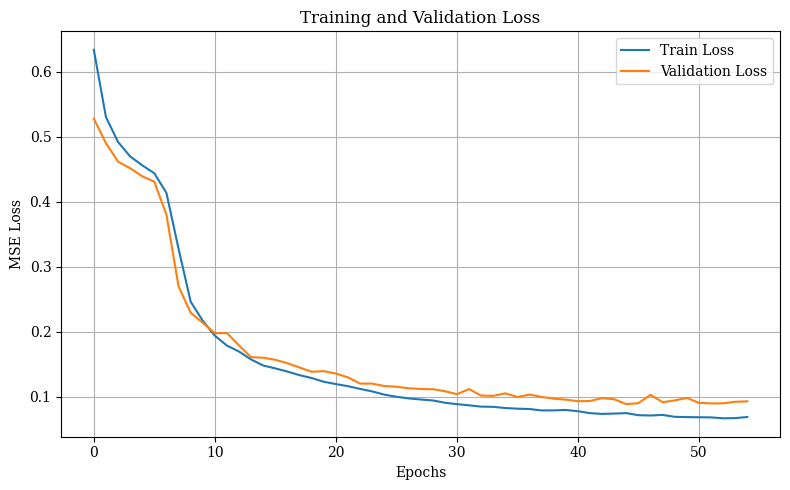

In [78]:
# === Step 1: Import Required Libraries ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, RepeatVector,
    TimeDistributed, Dense, Dropout, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import joblib

# === Step 2: Load Data ===
X = np.load('/content/X_windows.npy')
y = np.load('/content/y_windows.npy')  # used only for evaluation

# === Step 3: Filter Normal Windows for Training ===
X_normal = X[y == 0]

# === Step 4: Temporal Split: 70% train, 10% val, 20% test ===
n_total = len(X_normal)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val

X_train = X_normal[:n_train]
X_val = X_normal[n_train:n_train + n_val]
X_test = X_normal[n_train + n_val:]

# === Step 5: Fix NaNs and Normalize ===
X_train = np.nan_to_num(X_train, nan=0.0)
X_val = np.nan_to_num(X_val, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Save fitted scaler
joblib.dump(scaler, '/content/standard_scaler.pkl')

print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

# === Step 6: Build Improved CNN-LSTM Autoencoder ===
def build_autoencoder(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(inp)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = RepeatVector(input_shape[0])(x)
    x = LSTM(32, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = TimeDistributed(Dense(input_shape[1]))(x)
    return Model(inputs=inp, outputs=x)

input_shape = X_train_scaled.shape[1:]
model = build_autoencoder(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# === Step 7: Callbacks ===
checkpoint = ModelCheckpoint(
    'final_disaster_model.keras', monitor='val_loss', mode='min',
    save_best_only=True, verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, min_delta=0.0001,
    restore_best_weights=True, verbose=1
)

# === Step 8: Train Model ===
history = model.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_val_scaled, X_val_scaled),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# === Step 9: Plot Training History ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_validation_loss.png", dpi=300)
plt.show()


In [79]:
print("NaNs in X_train:", np.isnan(X_train).sum())
print("Infs in X_train:", np.isinf(X_train).sum())

NaNs in X_train: 0
Infs in X_train: 0


In [80]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [81]:
# === Step 1: Import Libraries ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve
from tensorflow.keras.models import load_model

# === Step 2: Load Files ===
X = np.load('/content/X_windows.npy')
X = np.nan_to_num(X, nan=0.0)  # Fix NaNs before prediction
y_true = np.load('/content/y_windows.npy')
lat = np.load('/content/lat_windows.npy')
lon = np.load('/content/lon_windows.npy')

# Load best trained model
model = load_model('/content/final_disaster_model.keras')

# === Step 3: Get Reconstruction Errors ===
X_pred = model.predict(X)
mse = np.mean(np.power(X - X_pred, 2), axis=(1, 2))

# === Step 4: Threshold Finder (Precision-Recall Curve) ===
precision, recall, thresholds = precision_recall_curve(y_true, mse)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold = {best_threshold:.4f} (F1 = {f1_scores[best_idx]:.4f})")


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Best Threshold = 0.2101 (F1 = 0.4848)


In [82]:
# === Step 5: Predict Anomalies ===
y_pred = (mse > best_threshold).astype(int)

# === Step 6: Classification Report ===
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Confusion Matrix:
[[   0 5581]
 [   1 2625]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      5581
           1     0.3199    0.9996    0.4847      2626

    accuracy                         0.3198      8207
   macro avg     0.1599    0.4998    0.2423      8207
weighted avg     0.1024    0.3198    0.1551      8207



Loaded model and data.
X_test shape: (1643, 8, 13)
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Reconstructions done.
Removed 775 NaN entries from reconstruction error.
Valid entries for thresholding: 868

Best Threshold: 2.31625e-01, F1 = 0.4143

Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.07      0.13       647
    Disaster       0.26      0.97      0.41       221

    accuracy                           0.30       868
   macro avg       0.56      0.52      0.27       868
weighted avg       0.71      0.30      0.20       868

Confusion Matrix:
 [[ 45 602]
 [  7 214]]


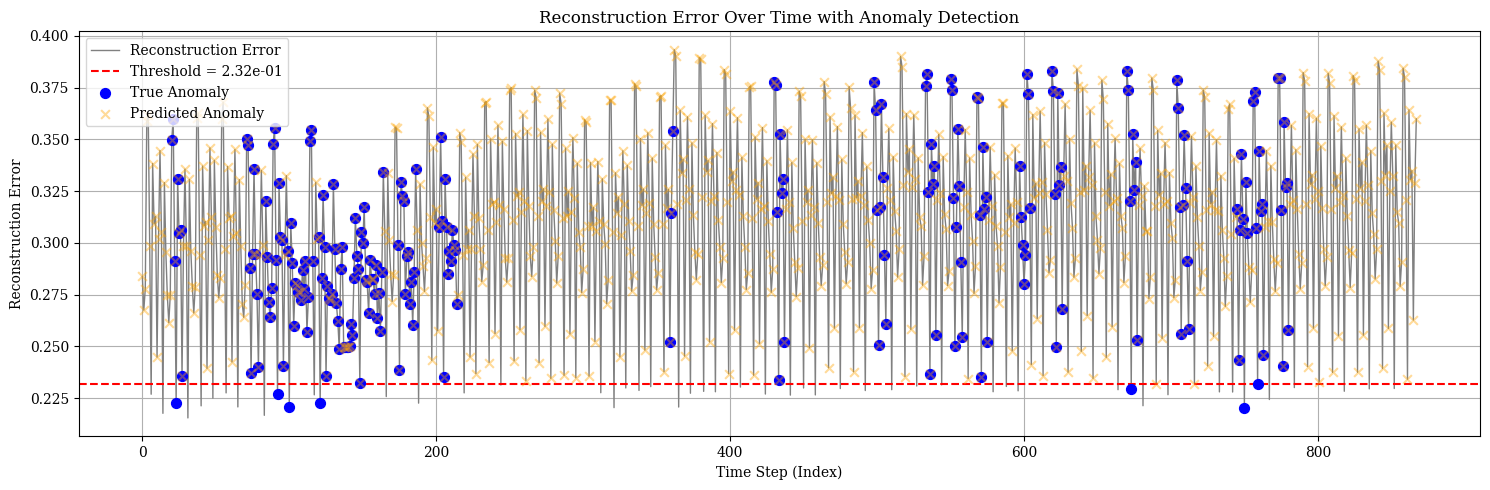

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# === Step 1: Load Saved Model and Test Data ===
from tensorflow.keras.models import load_model

model_path = '/content/final_disaster_model.keras'
X_test = np.load('/content/X_test.npy')         # Shape: (samples, timesteps, features)
y_true = np.load('/content/y_test.npy')         # Shape: (samples,)

model = load_model(model_path)
print("Loaded model and data.")
print(f"X_test shape: {X_test.shape}")

# === Step 2: Predict Reconstructions ===
X_pred = model.predict(X_test)
print("Reconstructions done.")

# === Step 3: Compute Reconstruction Errors ===
# MSE for each sample
mse = np.mean(np.mean(np.square(X_test - X_pred), axis=1), axis=1)

# === Step 4: Remove NaNs if any ===
nan_mask = ~np.isnan(mse)
mse_clean = mse[nan_mask]
y_true_clean = y_true[nan_mask]

print(f"Removed {np.sum(~nan_mask)} NaN entries from reconstruction error.")
print(f"Valid entries for thresholding: {len(mse_clean)}")

# === Step 5: Precision-Recall Threshold Selection ===
precision, recall, thresholds = precision_recall_curve(y_true_clean, mse_clean)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
threshold = thresholds[best_idx]

print(f"\nBest Threshold: {threshold:.5e}, F1 = {f1_scores[best_idx]:.4f}")

# === Step 6: Predict Anomalies ===
y_pred = (mse_clean > threshold).astype(int)

# === Step 7: Classification Report ===
print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred, target_names=["Normal", "Disaster"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_true_clean, y_pred)
print("Confusion Matrix:\n", cm)

# === Step 9: Plot Reconstruction Errors with Threshold ===
plt.figure(figsize=(15, 5))
plt.plot(mse_clean, label='Reconstruction Error', color='gray', linewidth=1)

# Threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2e}')

# True Anomalies
true_anomaly_idx = np.where(y_true_clean == 1)[0]
plt.scatter(true_anomaly_idx, mse_clean[true_anomaly_idx], color='blue', label='True Anomaly', s=50, zorder=3)

# Predicted Anomalies
pred_anomaly_idx = np.where(y_pred == 1)[0]
plt.scatter(pred_anomaly_idx, mse_clean[pred_anomaly_idx], color='orange', label='Predicted Anomaly', marker='x', alpha=0.4, s=40, zorder=3)

# Labels
plt.xlabel('Time Step (Index)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time with Anomaly Detection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("anomaly_over_time.png", dpi=300)
plt.show()


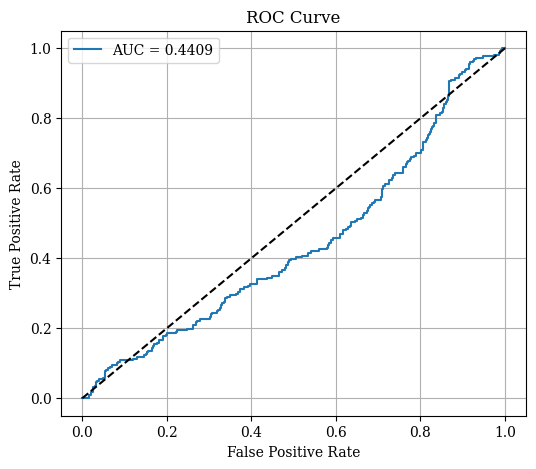

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score

# === Step 7: ROC Curve (Use mse_clean and y_true_clean) ===
fpr, tpr, _ = roc_curve(y_true_clean, mse_clean)
auc = roc_auc_score(y_true_clean, mse_clean)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig("roc_curve.png", dpi=300)
plt.show()


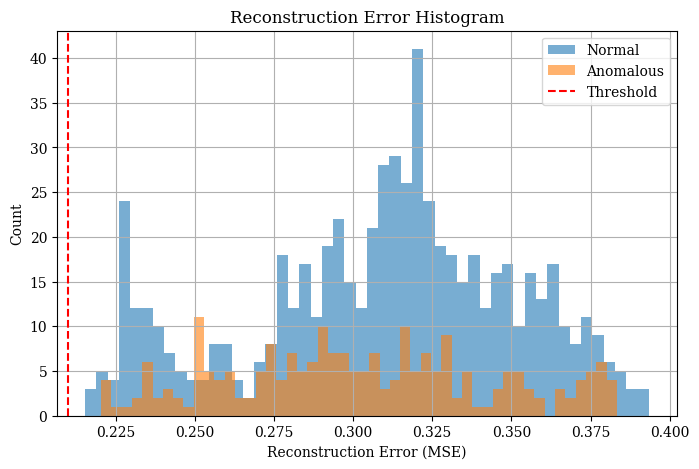

In [88]:

# === Step 8: Histogram of Reconstruction Errors ===
plt.figure(figsize=(8, 5))
plt.hist(mse[y_true == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse[y_true == 1], bins=50, alpha=0.6, label='Anomalous')
plt.axvline(best_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Reconstruction Error Histogram')
plt.legend()
plt.grid(True)
plt.savefig("reconstruction_error_histogram.png", dpi=300)
plt.show()

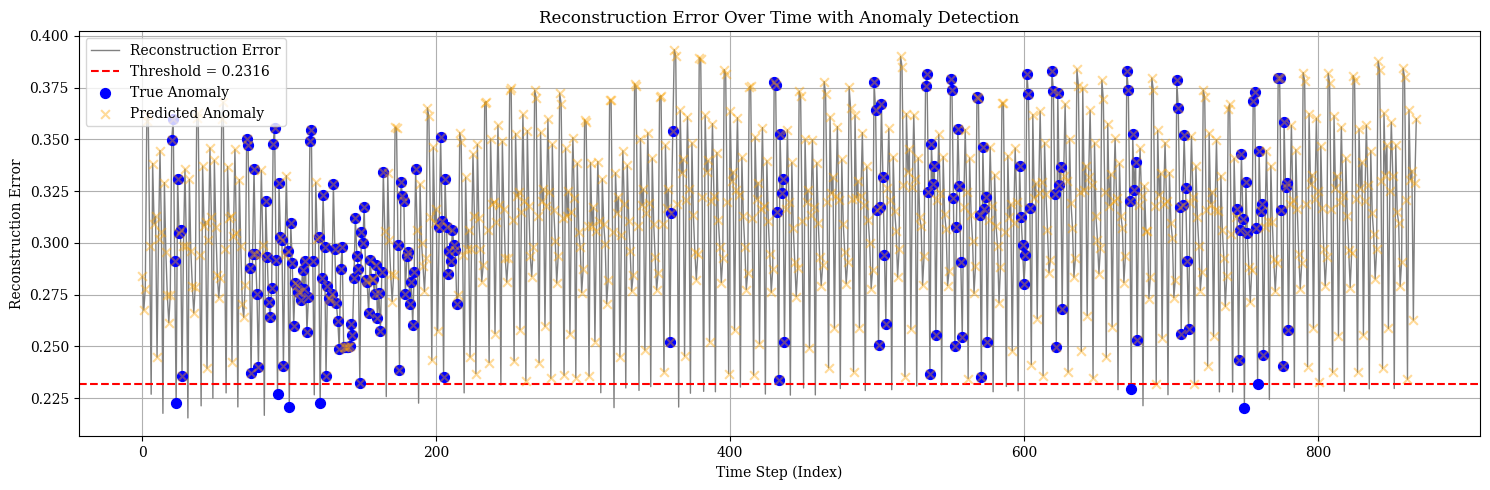

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# === Load or compute your mse and y_true ===
# mse = np.load('mse.npy')
# y_true = np.load('y_windows.npy')

# === Step 1: Remove NaN values ===
nan_mask = ~np.isnan(mse)
mse_clean = mse[nan_mask]
y_true_clean = y_true[nan_mask]

# === Step 2: Compute threshold from PR curve ===
precision, recall, thresholds = precision_recall_curve(y_true_clean, mse_clean)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
threshold = thresholds[best_idx]

# === Step 3: Predict anomalies ===
y_pred = (mse_clean > threshold).astype(int)

# === Step 4: Plot reconstruction error over time ===
plt.figure(figsize=(15, 5))
plt.plot(mse_clean, label='Reconstruction Error', color='gray', linewidth=1)

# Plot threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')

# Mark true anomalies
true_anomaly_idx = np.where(y_true_clean == 1)[0]
plt.scatter(true_anomaly_idx, mse_clean[true_anomaly_idx], color='blue', label='True Anomaly', s=50, zorder=3)

# Mark predicted anomalies
pred_anomaly_idx = np.where(y_pred == 1)[0]
plt.scatter(pred_anomaly_idx, mse_clean[pred_anomaly_idx], color='orange', label='Predicted Anomaly', marker='x', alpha=0.4, s=40, zorder=3)

# Labels
plt.xlabel('Time Step (Index)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time with Anomaly Detection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("anomaly_over_time.png", dpi=300)
plt.show()


# Anomaly Map Visualization Over Time (for Satellite Windows)
Generate a time-series plot of:

reconstruction error

true anomalies

predicted anomalies (above threshold)

257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Optimal Threshold = 2.10055e-01, F1 = 0.4848


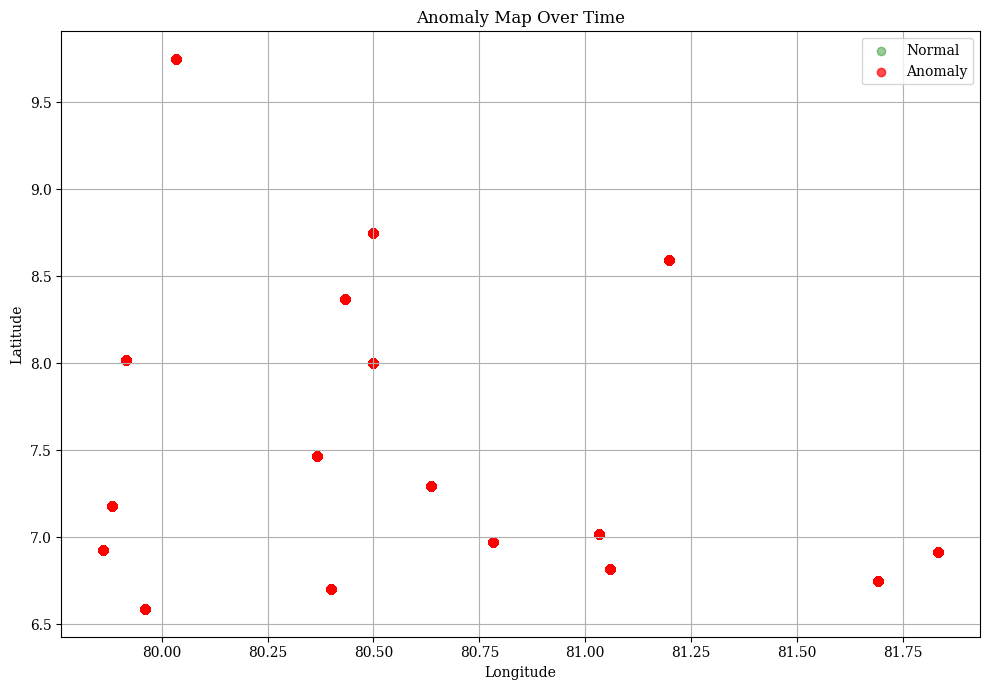

✅ Saved anomaly map and CSV.


In [97]:
# === Step 0: Import Libraries ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve

# === Step 1: Load Model and Data ===
model_path = '/content/final_disaster_model.keras'
X = np.load('/content/X_windows.npy')                   # shape: (samples, timesteps, features)
y_true = np.load('/content/y_windows.npy')              # shape: (samples,)
lat = np.load('/content/lat_windows.npy')
lon = np.load('/content/lon_windows.npy')

# Optional: Handle NaNs in X
X = np.nan_to_num(X, nan=0.0)

# === Step 2: Run Reconstruction ===
model = load_model(model_path)
X_pred = model.predict(X, verbose=1)

# === Step 3: Compute Reconstruction Error (MSE per sample) ===
mse = np.mean(np.mean(np.square(X - X_pred), axis=1), axis=1)

# === Step 4: Clean NaNs (if any)
valid_mask = ~np.isnan(mse)
mse_clean = mse[valid_mask]
y_true_clean = y_true[valid_mask]
lat = lat[valid_mask]
lon = lon[valid_mask]

# === Step 5: Select Threshold from Precision-Recall ===
precision, recall, thresholds = precision_recall_curve(y_true_clean, mse_clean)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
threshold = thresholds[best_idx]
print(f"Optimal Threshold = {threshold:.5e}, F1 = {f1_scores[best_idx]:.4f}")

# === Step 6: Predict Anomalies ===
y_pred = (mse_clean > threshold).astype(int)

# === Step 7: Create Synthetic Dates (if not available)
start_date = pd.to_datetime('2018-10-01')  # adjust if needed
dates = pd.date_range(start=start_date, periods=len(y_pred), freq='D')

# === Step 8: Create DataFrame for Visualization ===
df = pd.DataFrame({
    'date': dates,
    'latitude': lat,
    'longitude': lon,
    'prediction': y_pred
})
df['label'] = df['prediction'].map({0: 'Normal', 1: 'Anomaly'})

# === Step 9: Plot Anomaly Map ===
plt.figure(figsize=(10, 7))
plt.scatter(df[df['label'] == 'Normal']['longitude'], df[df['label'] == 'Normal']['latitude'],
            c='green', label='Normal', alpha=0.4)
plt.scatter(df[df['label'] == 'Anomaly']['longitude'], df[df['label'] == 'Anomaly']['latitude'],
            c='red', label='Anomaly', alpha=0.7)
'''
# Annotate some anomaly dates
for i in df[df['label'] == 'Anomaly'].index[::25]:  # every 25th
    plt.text(df.loc[i, 'longitude'], df.loc[i, 'latitude'], str(df.loc[i, 'date'].date()),
             fontsize=6, alpha=0.6)
'''
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Anomaly Map Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("anomaly_map_over_time.png", dpi=300)
plt.show()

# === Step 10: Save Outputs ===
df.to_csv('/content/anomaly_map_over_time.csv', index=False)
print("✅ Saved anomaly map and CSV.")


Re-tune Threshold Dynamically

## Retrain with Synthetic Anomalies or Rebalanced Dataset

In [98]:
# === Step 0: Import Libraries ===
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, RepeatVector, TimeDistributed, Dense, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# === Step 1: Load Data ===
X_windows = np.load('/content/X_windows.npy')  # shape: (n, timesteps, features)
y_windows = np.load('/content/y_windows.npy')  # shape: (n,)

# Temporal Split (70% train, 10% val, 20% test)
n_total = len(X_windows)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

X_train = X_windows[:n_train]
y_train = y_windows[:n_train]
X_val = X_windows[n_train:n_train + n_val]
y_val = y_windows[n_train:n_train + n_val]
X_test = X_windows[n_train + n_val:]
y_test = y_windows[n_train + n_val:]

# Save test set for reuse
np.save('/content/X_test.npy', X_test)
np.save('/content/y_test.npy', y_test)

print("Original X_train shape:", X_train.shape)

# === Step 2: Oversample Anomalies ===
X_normal = X_train[y_train == 0]
X_anomaly = X_train[y_train == 1]

repeat_factor = 10  # Tune this if needed
X_anomaly_aug = np.tile(X_anomaly, (repeat_factor, 1, 1))

X_rebalanced = np.concatenate([X_normal, X_anomaly_aug], axis=0)

# Shuffle
np.random.shuffle(X_rebalanced)

# === Step 3: Normalize Features ===
# === Step 3: Normalize Features (with NaN fix) ===
scaler = StandardScaler()
n_samples, seq_len, n_features = X_rebalanced.shape

# Flatten and fix NaNs
X_reb_flat = X_rebalanced.reshape(-1, n_features)
nan_mask = np.isnan(X_reb_flat)
if nan_mask.any():
    col_means = np.nanmean(X_reb_flat, axis=0)
    X_reb_flat[nan_mask] = np.take(col_means, np.where(nan_mask)[1])

# Fit and scale
X_reb_scaled = scaler.fit_transform(X_reb_flat).reshape(n_samples, seq_len, n_features)

# === Fix Test Set NaNs ===
X_test_flat = X_test.reshape(-1, n_features)
nan_mask_test = np.isnan(X_test_flat)
if nan_mask_test.any():
    X_test_flat[nan_mask_test] = np.take(col_means, np.where(nan_mask_test)[1])
# Normalize test set for later inference
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

# === Step 4: Build CNN-LSTM Autoencoder ===
def build_cnn_lstm_autoencoder3(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inp)
    x = MaxPooling1D(2, padding='same')(x)
    x = LSTM(32, return_sequences=False)(x)
    x = RepeatVector(input_shape[0] // 2)(x)
    x = LSTM(32, return_sequences=True)(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(input_shape[1], kernel_size=3, activation='linear', padding='same')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(1e-3, clipnorm=1.0), loss='mse')
    return model

# === Step 5: Train Model ===
model = build_cnn_lstm_autoencoder3(X_reb_scaled.shape[1:])

# Check for NaNs
print("NaNs in training data:", np.isnan(X_reb_scaled).any())

# Split validation from rebalanced
X_train_reb, X_val_reb = train_test_split(X_reb_scaled, test_size=0.1, random_state=42)

checkpoint_path = "/content/rebalanced_autoencoder.keras"
early_stop = EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.0001, verbose=1)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

history = model.fit(
    X_train_reb, X_train_reb,
    validation_data=(X_val_reb, X_val_reb),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# === Step 6: Inference on Test Set ===
if os.path.exists(checkpoint_path):
    model = tf.keras.models.load_model(checkpoint_path)
    print("Loaded model from:", checkpoint_path)
else:
    print("Trained model not found!")
    exit()

# Normalize test set already done: X_test_scaled
X_test_pred = model.predict(X_test_scaled)
reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_pred), axis=(1, 2))

# === Step 7: Evaluate Threshold ===
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_errors)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nBest Threshold: {best_threshold:.5f}")

# === Step 8: Final Evaluation ===
y_pred = (reconstruction_errors > best_threshold).astype(int)
print("\nClassification Report:")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Original X_train shape: (5744, 8, 13)
NaNs in training data: False
Epoch 1/300
657/664 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6654
Epoch 1: val_loss improved from inf to 0.41261, saving model to /content/rebalanced_autoencoder.keras
664/664 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.6641 - val_loss: 0.4126
Epoch 2/300
656/664 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3526
Epoch 2: val_loss improved from 0.41261 to 0.23500, saving model to /content/rebalanced_autoencoder.keras
664/664 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3523 - val_loss: 0.2350
Epoch 3/300
661/664 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2094
Epoch 3: val_loss improved from 0.23500 to 0.15957, saving model to /content/rebalanced_autoencoder.keras
664/664 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2092 - val_loss: 0.1596
Epoch 4/300
657/664 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1557
Epoch 4: val_loss improved from 0.15957 to 0.13820, saving model to /content/rebalanced_autoencoder.keras
664/664 ━━━━━━━━

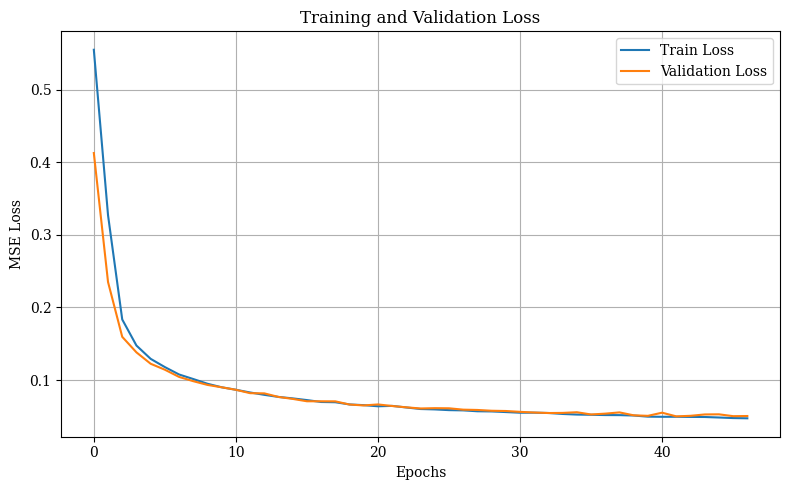

In [102]:
import matplotlib.pyplot as plt

# === Step: Plot Training History ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("attention_autoencoder_loss.png", dpi=300)
plt.show()


In [103]:
# === Step 1: Import Libraries ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve
from tensorflow.keras.models import load_model

# === Step 2: Load Files ===
X = np.load('/content/X_windows.npy')
X = np.nan_to_num(X, nan=0.0)  # Fix NaNs before prediction
y_true = np.load('/content/y_windows.npy')
lat = np.load('/content/lat_windows.npy')
lon = np.load('/content/lon_windows.npy')

# Load best trained model
model = load_model('/content/rebalanced_autoencoder.keras')

# === Step 3: Get Reconstruction Errors ===
X_pred = model.predict(X)
mse = np.mean(np.power(X - X_pred, 2), axis=(1, 2))

# === Step 4: Threshold Finder (Precision-Recall Curve) ===
precision, recall, thresholds = precision_recall_curve(y_true, mse)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold = {best_threshold:.4f} (F1 = {f1_scores[best_idx]:.4f})")


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Best Threshold = 0.0115 (F1 = 0.4848)


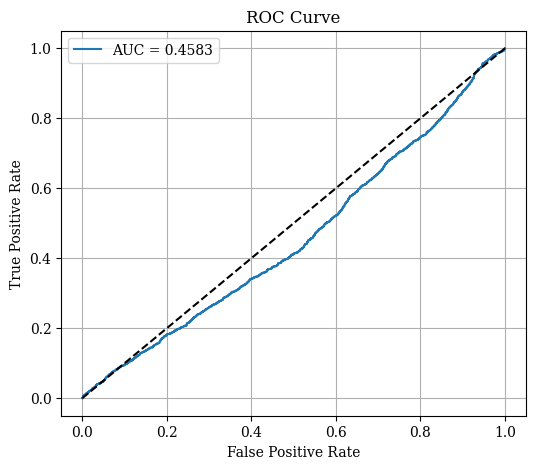

In [104]:
from sklearn.metrics import roc_curve, roc_auc_score

# === Step 7: ROC Curve (Use mse_clean and y_true_clean) ===
fpr, tpr, _ = roc_curve(y_true_clean, mse_clean)
auc = roc_auc_score(y_true_clean, mse_clean)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig("roc_curve.png", dpi=300)
plt.show()


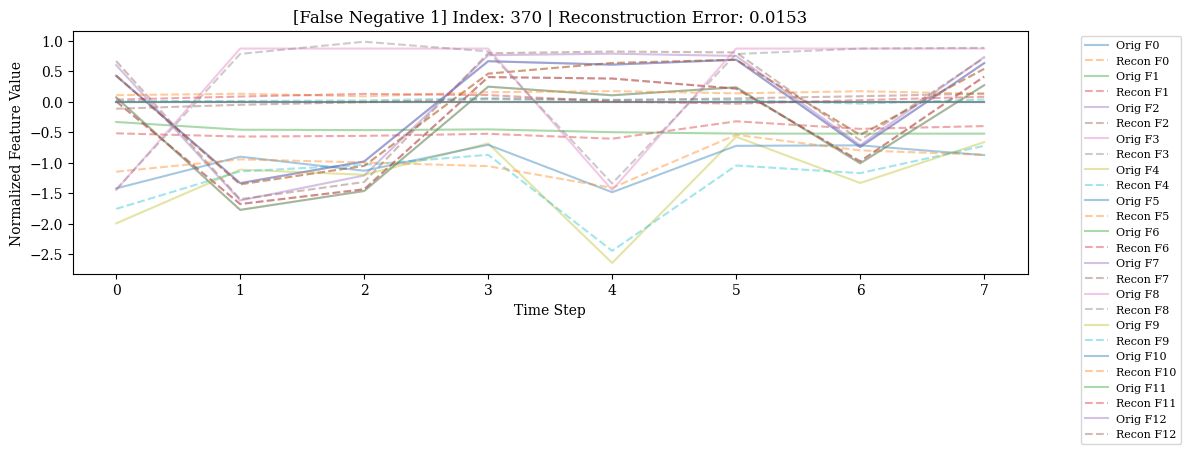

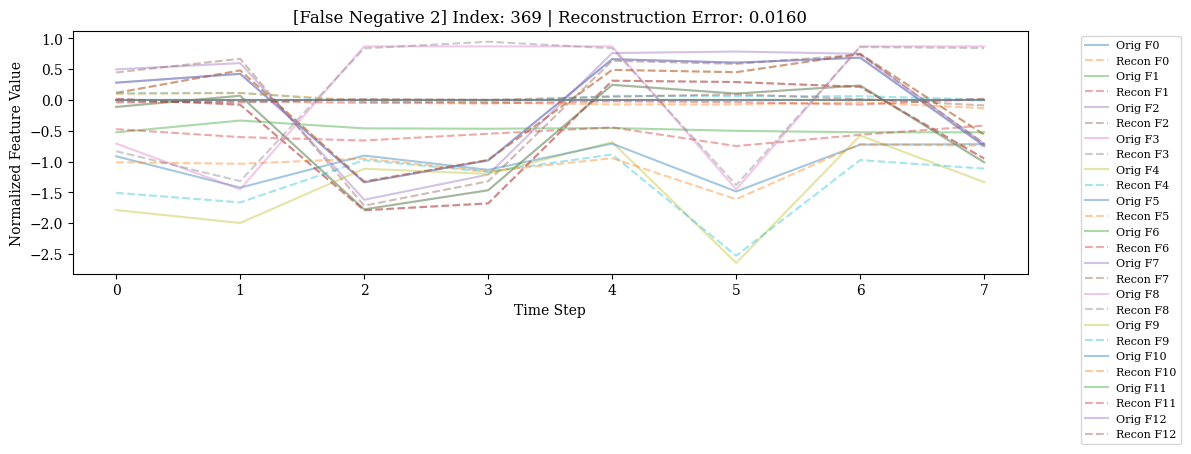

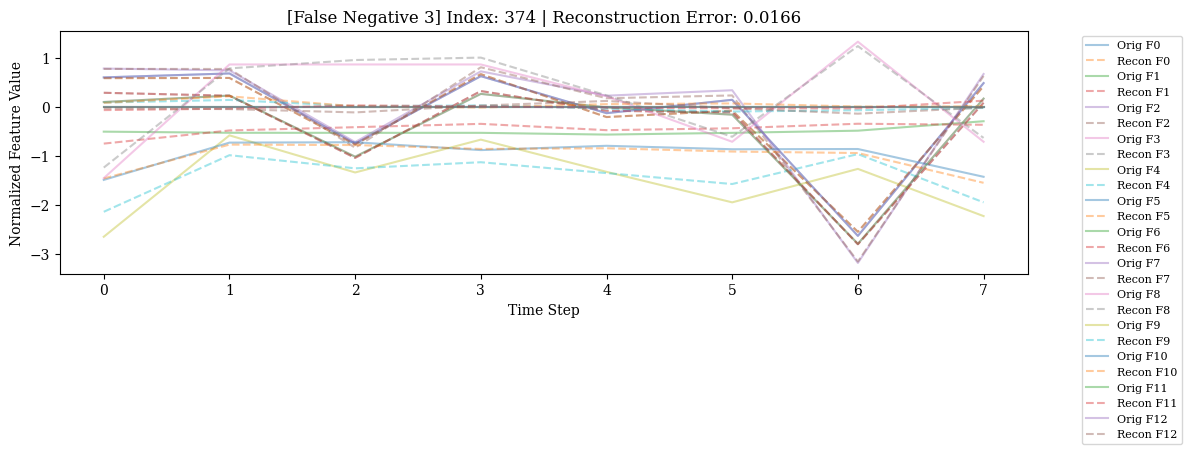

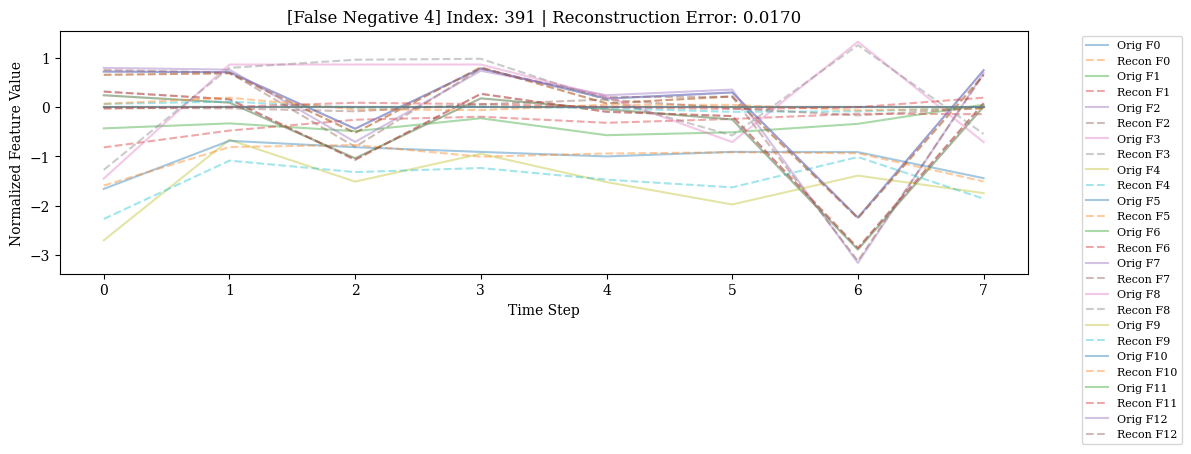

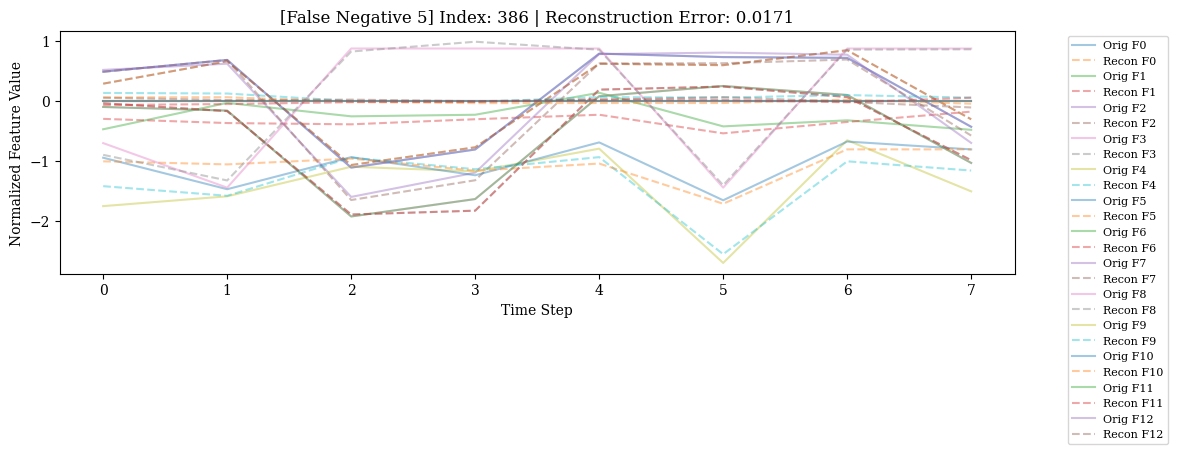

In [99]:
import matplotlib.pyplot as plt

# === Step 1: Identify false negatives ===
false_negatives_idx = np.where((y_test == 1) & (y_pred == 0))[0]
fn_errors = reconstruction_errors[false_negatives_idx]

# === Step 2: Sort by reconstruction error (lowest first) ===
sorted_idx = false_negatives_idx[np.argsort(fn_errors)]

# === Step 3: Plot top N false negatives ===
N = 5  # Number of false negatives to visualize

for i, idx in enumerate(sorted_idx[:N]):
    original = X_test_scaled[idx]
    reconstructed = X_test_pred[idx]

    plt.figure(figsize=(12, 4))
    for feature in range(original.shape[1]):
        plt.plot(original[:, feature], label=f"Orig F{feature}", alpha=0.4, linestyle='-')
        plt.plot(reconstructed[:, feature], label=f"Recon F{feature}", alpha=0.4, linestyle='--')

    plt.title(f"[False Negative {i+1}] Index: {idx} | Reconstruction Error: {reconstruction_errors[idx]:.4f}")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Feature Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"Reconstruction_Error{idx}.png", dpi=300)
    plt.show()
    print()


In [100]:
import pandas as pd

# Create DataFrame with results
df_results = pd.DataFrame({
    'true_label': y_test,
    'reconstruction_error': reconstruction_errors,
    'predicted_label': y_pred
})

# Optional: Include date/index if available
# df_results['date'] = your_date_list  # if you have a date column

# Save to CSV
df_results.to_csv("anomaly_detection_results.csv", index=False)
print("Saved as anomaly_detection_results.csv")


Saved as anomaly_detection_results.csv


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Reconstruction errors saved!


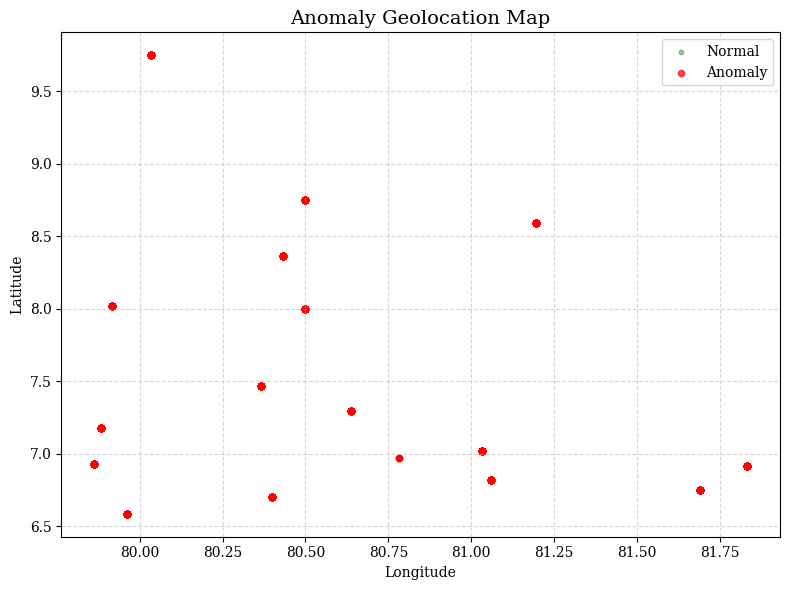

In [101]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# === Load data ===
X = np.load('/content/X_windows.npy')           # shape: (7933, 8, 13)
lat = np.load('/content/lat_windows.npy')       # shape: (7933,)
lon = np.load('/content/lon_windows.npy')       # shape: (7933,)

# === Load trained autoencoder ===
model = load_model('/content/rebalanced_autoencoder.keras')  # update path if needed

# === Get predictions ===
X_pred = model.predict(X)

# === Compute reconstruction errors (MSE per sample) ===
errors = np.mean(np.mean((X - X_pred) ** 2, axis=1), axis=1)  # shape: (7933,)

# === Save for future use ===
np.save('/content/reconstruction_errors.npy', errors)
print("Reconstruction errors saved!")

import numpy as np
import matplotlib.pyplot as plt

# === Load metadata and errors ===
lat = np.load('/content/lat_windows.npy')  # shape: (7933,)
lon = np.load('/content/lon_windows.npy')
errors = np.load('/content/reconstruction_errors.npy')  # shape: (7933,)
threshold = 0.08158  # replace with your chosen threshold

# === Classify anomalies ===
labels = (errors > threshold).astype(int)  # 1 = anomaly, 0 = normal

# === Plot ===
plt.figure(figsize=(8, 6))
plt.title("Anomaly Geolocation Map", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Plot normal windows
plt.scatter(lon[labels == 0], lat[labels == 0], c='green', s=10, label='Normal', alpha=0.4)

# Plot anomalies
plt.scatter(lon[labels == 1], lat[labels == 1], c='red', s=20, label='Anomaly', alpha=0.7)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Anomaly_Geolocation_Map.png", dpi=300)
plt.show()


## Attention-based LSTM Autoencoder
Encoder: LSTM encodes the input sequence to a latent vector.

Decoder: LSTM reconstructs the sequence, using attention to focus on relevant time steps.

Attention Layer: Learns to weigh which encoder time steps matter most to each decoder step.



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === Custom Attention Layer ===
class AttentionLayer(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.V = self.add_weight(name='att_score_vec', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=1), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        if self.return_attention:
            return context_vector, attention_weights
        return context_vector


# === Build Attention-based LSTM Autoencoder ===
def build_attention_lstm_autoencoder(input_shape):
    inp = Input(shape=input_shape)

    # Encoder
    encoded_seq, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(inp)

    # Attention over encoder outputs
    context = AttentionLayer()(encoded_seq)

    # Repeat context for each time step
    repeated_context = RepeatVector(input_shape[0])(context)

    # Decoder
    decoded = LSTM(64, return_sequences=True)(repeated_context)
    output = TimeDistributed(Dense(input_shape[1]))(decoded)

    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer=Adam(1e-3, clipnorm=1.0), loss='mse')
    return model

# === Example usage ===
# X_train_final = normalized training input: shape (n_samples, time_steps, features)
model = build_attention_lstm_autoencoder(X_reb_scaled.shape[1:])

# Callbacks


checkpoint_path = "/content/attention_autoencoder.keras"
early_stop = EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.0001, verbose=1)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train
history = model.fit(
    X_train_reb, X_train_reb,
    validation_data=(X_val_reb, X_val_reb),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/200
328/330 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6457
Epoch 1: val_loss improved from inf to 0.49323, saving model to /content/attention_autoencoder.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.6450 - val_loss: 0.4932
Epoch 2/200
329/330 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3733
Epoch 2: val_loss improved from 0.49323 to 0.21466, saving model to /content/attention_autoencoder.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.3729 - val_loss: 0.2147
Epoch 3/200
327/330 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1697
Epoch 3: val_loss improved from 0.21466 to 0.15475, saving model to /content/attention_autoencoder.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1697 - val_loss: 0.1548
Epoch 4/200
328/330 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1455
Epoch 4: val_loss improved from 0.15475 to 0.13011, saving model to /content/attention_autoencoder.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1454 - val_loss: 0.1301
Ep

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


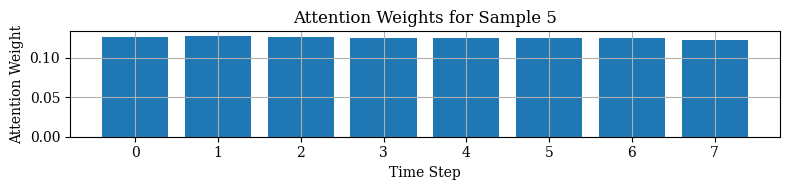

In [ ]:
# Rebuild attention model to extract attention weights
input_sample = Input(shape=X_val_reb.shape[1:])
lstm_out, _, _ = LSTM(64, return_sequences=True, return_state=True)(input_sample)
context_vec, att_weights = AttentionLayer(return_attention=True)(lstm_out)

attention_model = Model(inputs=input_sample, outputs=att_weights)

# Choose a sample to inspect (e.g., index 10)
sample_idx = 5
sample_input = X_val_reb[sample_idx:sample_idx+1]

# Get attention weights (shape: 1 x timesteps x 1)
weights = attention_model.predict(sample_input).squeeze()

# Plot heatmap
plt.figure(figsize=(8, 2))
plt.bar(range(len(weights)), weights)
plt.title(f"Attention Weights for Sample {sample_idx}")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.grid(True)
plt.tight_layout()
plt.savefig("attention_weights_sample.png", dpi=300)
plt.show()


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


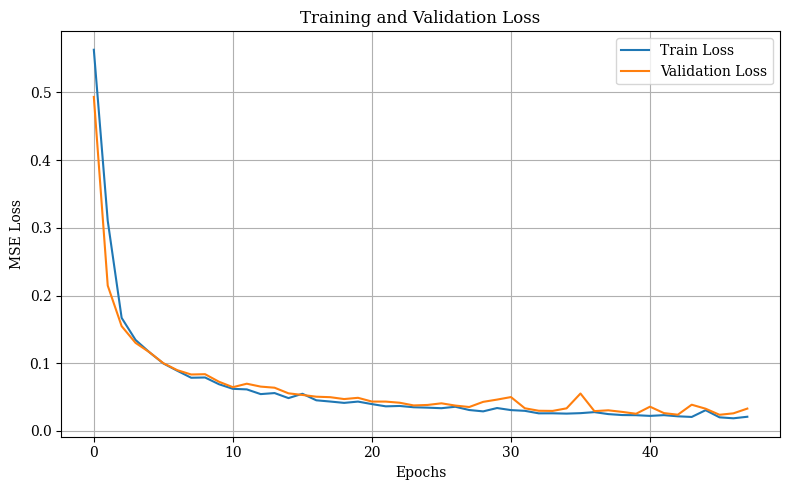

In [ ]:
import matplotlib.pyplot as plt

# === Step: Plot Training History ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("attention_autoencoder_loss.png", dpi=300)
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


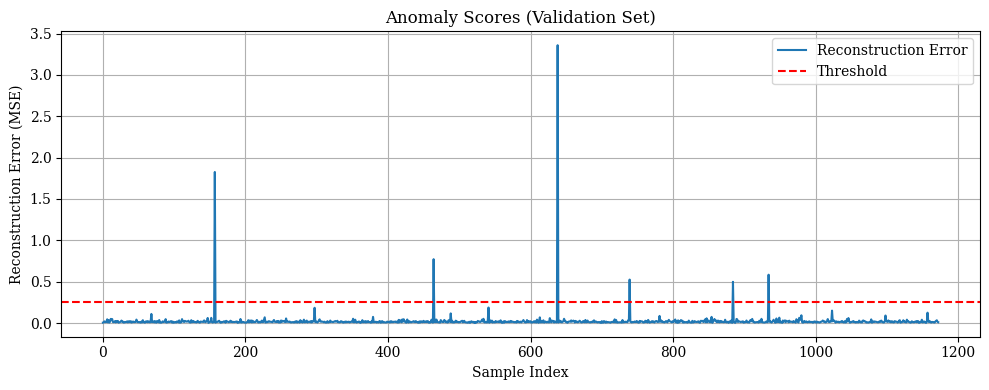

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Predict Reconstruction ===
X_val_pred = model.predict(X_val_reb)

# === Step 2: Compute Reconstruction Errors ===
reconstruction_errors = np.mean(np.mean(np.square(X_val_reb - X_val_pred), axis=1), axis=1)

# === Step 3: Plot Anomaly Scores ===
plt.figure(figsize=(10, 4))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors), color='r', linestyle='--', label='Threshold')
plt.title("Anomaly Scores (Validation Set)")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("attention_anomaly_scores.png", dpi=300)
plt.show()


In [ ]:
# Predict labels
y_pred_binary = (reconstruction_errors > best_threshold).astype(int)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1302
           1       0.49      0.36      0.41       285

    accuracy                           0.82      1587
   macro avg       0.68      0.64      0.65      1587
weighted avg       0.80      0.82      0.81      1587


Confusion Matrix:
[[1193  109]
 [ 182  103]]


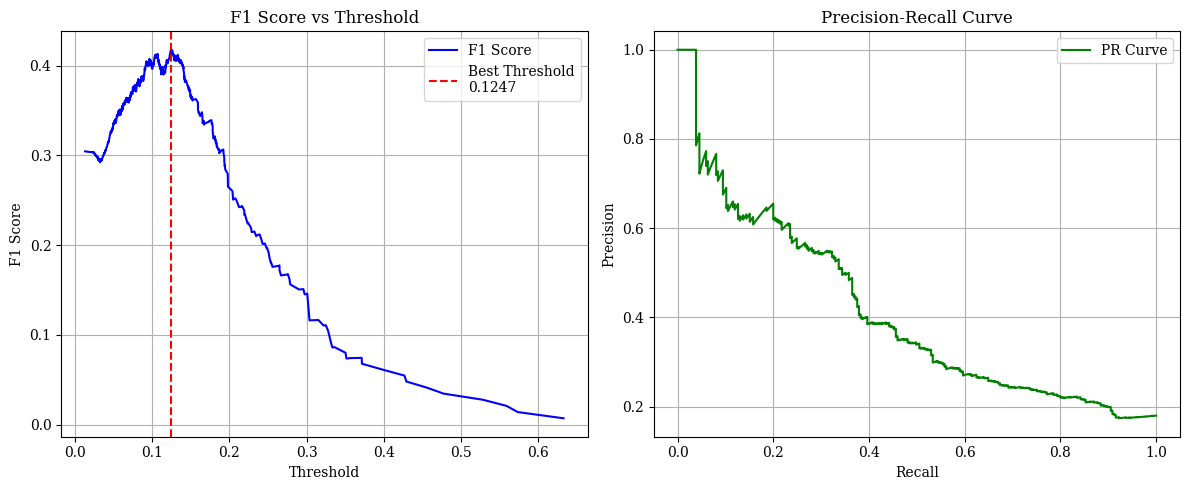

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# === F1 Score vs Threshold (matching lengths) ===
plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='blue')  # Fix here
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold\n{best_threshold:.4f}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.savefig("F1_Score_vs_Threshold.png", dpi=300, bbox_inches='tight')

# === Precision-Recall Curve ===
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='PR Curve', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Precision_Recall_Curve.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import os
import shutil
from glob import glob

# Target Google Drive path
drive_base = '/content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/'
os.makedirs(drive_base, exist_ok=True)

# Copy all .jpg and .png files to drive_base
image_files = glob("*.jpg") + glob("*.png")
for img_file in image_files:
    dest_path = os.path.join(drive_base, os.path.basename(img_file))
    shutil.copy(img_file, dest_path)
    print(f"Copied: {img_file} → {dest_path}")


Copied: attention_autoencoder_loss.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/attention_autoencoder_loss.png
Copied: Reconstruction_Error101.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/Reconstruction_Error101.png
Copied: attention_weights_sample.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/attention_weights_sample.png
Copied: F1_Score_vs_Threshold.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/F1_Score_vs_Threshold.png
Copied: ainfall_flood_Frequency.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/ainfall_flood_Frequency.png
Copied: Reconstruction_Error318.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/Reconstruction_Error318.png
Copied: roc_curve.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/roc_curve.png
Copied: reconstruction_error_histogram.png → /content/drive/MyDrive/Mphil/MyPapers/LKenv/figures2/reconstruction_error_histogram.png
Copied: anomaly_over_time.png → /content/drive/MyDrive/Mph

In [106]:
import os
import shutil

drive_base = '/content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/'
os.makedirs(drive_base, exist_ok=True)

# Source file paths
file_list = [
    'final_disaster_model.keras',
    'rebalanced_autoencoder.keras',
    '/content/Disaster_Weather_Images_Merged.csv',
    '/content/X_train.npy',
    '/content/X_test.npy',
    '/content/y_test.npy',
     '/content/X_val.npy',
    '/content/standard_scaler.pkl',
    '/content/reconstruction_errors.npy'
]

# Copy files
for file_path in file_list:
    if os.path.exists(file_path):
        dest_path = os.path.join(drive_base, os.path.basename(file_path))
        shutil.copy(file_path, dest_path)
        print(f" Copied: {file_path} → {dest_path}")
    else:
        print(f" File not found: {file_path}")


 Copied: final_disaster_model.keras → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/final_disaster_model.keras
 Copied: rebalanced_autoencoder.keras → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/rebalanced_autoencoder.keras
 File not found: /content/Disaster_Weather_Images_Merged.csv
 File not found: /content/X_train.npy
 Copied: /content/X_test.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/X_test.npy
 Copied: /content/y_test.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/y_test.npy
 File not found: /content/X_val.npy
 Copied: /content/standard_scaler.pkl → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/standard_scaler.pkl
 Copied: /content/reconstruction_errors.npy → /content/drive/MyDrive/Mphil/MyPapers/LKenv/data4/reconstruction_errors.npy


## Inferencing
Setting missing metadata fields

Converting dewpoint_temperature_2m → dewpoint_temperature_2m_c

Calculating humidity

Extracting satellite .npy features

Generating model-ready (1, 8, 24) inference tensor

In [107]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import joblib

# === Parameters ===
city = "Kandy"
event_date = pd.to_datetime("2020-02-20")
window_size = 8
start_date = event_date - timedelta(days=window_size - 1)

# === Step 1: Load Raw Weather Data ===
df_weather = pd.read_csv("/content/SriLanka_daily_weather_data_2018_09_2025_06.csv", parse_dates=["date"])
df_weather = df_weather.sort_values("date")
df_city = df_weather[df_weather['city'].str.lower() == city.lower()]
df_window = df_city[(df_city['date'] >= start_date) & (df_city['date'] <= event_date)].copy()
assert df_window.shape[0] == window_size, "Incomplete 8-day weather data"

# === Step 2: Feature Engineering ===
df_window['temperature_2m_c'] = df_window['temperature_2m'] - 273.15
df_window['dewpoint_temperature_2m_c'] = df_window['dewpoint_temperature_2m'] - 273.15
T = df_window['temperature_2m_c']
Td = df_window['dewpoint_temperature_2m_c']
df_window['humidity'] = 100 * (
    np.exp((17.625 * Td) / (243.04 + Td)) / np.exp((17.625 * T) / (243.04 + T))
)
df_window['humidity'] = df_window['humidity'].clip(upper=100.0)
df_window.drop(columns=['dewpoint_temperature_2m'], inplace=True)

# === Step 3: Add Satellite Features ===
def load_satellite_features(date_str):
    npy_path = f"/content/sat_images/{date_str}.npy"
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        return {
            "mean_brightness": np.mean(arr),
            "std_brightness": np.std(arr),
            "max_brightness": np.max(arr),
            "min_brightness": np.min(arr)
        }
    else:
        print(f"Missing satellite image: {npy_path}")
        return {
            "mean_brightness": np.nan,
            "std_brightness": np.nan,
            "max_brightness": np.nan,
            "min_brightness": np.nan
        }

sat_features = [load_satellite_features(d.strftime("%Y-%m-%d")) for d in df_window['date']]
df_sat = pd.DataFrame(sat_features)
df_final = pd.concat([df_window.reset_index(drop=True), df_sat.reset_index(drop=True)], axis=1)

# === Step 4: Add Derived Feature ===
df_final['brightness_range'] = df_final['max_brightness'] - df_final['min_brightness']

# === Step 5: Define Training Feature Order ===
trained_feature_cols = [
    'rainfall_mm', 'surface_pressure', 'temperature_2m',
    'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'temperature_2m_c', 'dewpoint_temperature_2m_c', 'humidity',
    'mean_brightness', 'std_brightness', 'max_brightness',
    'min_brightness', 'brightness_range'
]

df_final = df_final[trained_feature_cols]

# === Step 6: Load Scaler and Normalize ===
scaler = joblib.load("/content/standard_scaler.pkl")
df_final = df_final.ffill().bfill()

X_scaled = scaler.transform(df_final.values)
# === Step 7: Reshape for Model Input ===
X_input = X_scaled.reshape(1, window_size, len(trained_feature_cols))

# === Step 8: Save or Predict ===
np.save("/content/X_infer.npy", X_input)
print("Inference input shape:", X_input.shape)
print("/content/X_infer.npy", "created")

Inference input shape: (1, 8, 13)
/content/X_infer.npy created


Inference and Classification

In [108]:
import numpy as np
from tensorflow.keras.models import load_model

# === Step 1: Load Inference Input ===
X_input = np.load('/content/X_infer.npy')  # shape: (1, 8, 13)

# === Step 2: Load Trained Autoencoder Model ===
model = load_model('/content/rebalanced_autoencoder.keras')

# === Step 3: Predict Reconstruction ===
X_recon = model.predict(X_input)

# === Step 4: Compute MSE ===
mse = np.mean(np.square(X_input - X_recon))
print(f"🔍 Reconstruction MSE: {mse:.5f}")

# === Step 5: Classify Based on Threshold ===
threshold = 0.08158  # Replace with your validated threshold
if mse > threshold:
    print( "Anomaly Detected!")
else:
    print("Normal Pattern")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
🔍 Reconstruction MSE: 325543354160.85999
Anomaly Detected!


Inter a date (e.g., "2020-02-20")

Prepares the 8-day window data for the city

Adds weather and satellite features

Normalizes using the trained scaler

Loads the trained Autoencoder

Predicts reconstruction

Prints the MSE and anomaly/normal result

In [113]:
# === Step 0: Setup ===
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import joblib
from tensorflow.keras.models import load_model

# === User Input ===
city = "Kandy"
event_date_str = input("Enter a date (YYYY-MM-DD): ")
event_date = pd.to_datetime(event_date_str)
window_size = 8
start_date = event_date - timedelta(days=window_size - 1)

# === Step 1: Load Weather Data ===
df_weather = pd.read_csv("/content/SriLanka_daily_weather_data_2018_09_2025_06.csv", parse_dates=["date"])
df_weather = df_weather.sort_values("date")
df_city = df_weather[df_weather['city'].str.lower() == city.lower()]
df_window = df_city[(df_city['date'] >= start_date) & (df_city['date'] <= event_date)].copy()
assert df_window.shape[0] == window_size, "* Incomplete 8-day weather data"

# === Step 2: Feature Engineering ===
df_window['temperature_2m_c'] = df_window['temperature_2m'] - 273.15
df_window['dewpoint_temperature_2m_c'] = df_window['dewpoint_temperature_2m'] - 273.15
T = df_window['temperature_2m_c']
Td = df_window['dewpoint_temperature_2m_c']
df_window['humidity'] = 100 * (
    np.exp((17.625 * Td) / (243.04 + Td)) / np.exp((17.625 * T) / (243.04 + T))
)
df_window['humidity'] = df_window['humidity'].clip(upper=100.0)
df_window.drop(columns=['dewpoint_temperature_2m'], inplace=True)

# === Step 3: Load Satellite Features ===
def load_satellite_features(date_str):
    npy_path = f"/content/sat_images/{date_str}.npy"
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        return {
            "mean_brightness": np.mean(arr),
            "std_brightness": np.std(arr),
            "max_brightness": np.max(arr),
            "min_brightness": np.min(arr)
        }
    else:
        print(f"Missing satellite image: {npy_path}")
        return {
            "mean_brightness": np.nan,
            "std_brightness": np.nan,
            "max_brightness": np.nan,
            "min_brightness": np.nan
        }

sat_features = [load_satellite_features(d.strftime("%Y-%m-%d")) for d in df_window['date']]
df_sat = pd.DataFrame(sat_features)
df_final = pd.concat([df_window.reset_index(drop=True), df_sat.reset_index(drop=True)], axis=1)
df_final['brightness_range'] = df_final['max_brightness'] - df_final['min_brightness']

# === Step 4: Select Features and Normalize ===
trained_feature_cols = [
    'rainfall_mm', 'surface_pressure', 'temperature_2m',
    'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'temperature_2m_c', 'dewpoint_temperature_2m_c', 'humidity',
    'mean_brightness', 'std_brightness', 'max_brightness',
    'min_brightness', 'brightness_range'
]
df_final = df_final[trained_feature_cols]
df_final = df_final.ffill().bfill()

scaler = joblib.load("/content/standard_scaler.pkl")
X_scaled = scaler.transform(df_final.values)
X_input = X_scaled.reshape(1, window_size, len(trained_feature_cols))
print(" Inference input shape:", X_input.shape)

# === Step 5: Predict with Autoencoder ===
model = load_model("/content/rebalanced_autoencoder.keras")
X_recon = model.predict(X_input)
mse = np.mean(np.square(X_input - X_recon))
print(f" Reconstruction MSE: {mse:.5f}")

# === Step 6: Anomaly Classification ===
threshold = 0.08158  # your validated threshold
if mse > threshold:
    print("Anomaly Detected!")
else:
    print(" Normal Pattern")


KeyboardInterrupt: Interrupted by user